In [8]:
import cobra
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns

from collections import defaultdict
from itertools import combinations, permutations
from matplotlib import rcParams
from os import listdir
from os.path import join
from scipy.spatial.distance import pdist, squareform
from scipy.stats import f_oneway, ttest_ind, fisher_exact, hypergeom
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from statsmodels.stats.multitest import multipletests

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['mathtext.it'] = 'Arial:italic'
rcParams['mathtext.bf'] = 'Arial:bold'

plot_dir = 'devStages_figures'
data_dir = 'devStages_data'

In [9]:
# Load AGORA taxa
df = pd.read_csv(data_dir + '/agora_taxa.tsv', delimiter='\t')
df['species'] = [x[1] for x in df.organism.str.split(' ')]
agora_tax_df = df
agora_tax_df

,organism,seedid,kingdom,phylum,mclass,order,family,genus,oxygenstat,metabolism,...,reactions,metabolites,draftcreator,draftcreated,phenotype,imgid,ncbiid,platform,kbaseid,species
0,Abiotrophia defectiva ATCC 49176,Abiotrophia defectiva ATCC 49176 (592010.4),Bacteria,Firmicutes,Bacilli,Lactobacillales,Aerococcaceae,Abiotrophia,Facultative anaerobe,"Saccharolytic, fermentative or respiratory",...,2428,1250,Eugen Bauer,07/01/14,1.0,2.562617e+09,592010.0,ModelSEED,NaN,defectiva
1,Achromobacter xylosoxidans A8,Achromobacter xylosoxidans A8 (762376.5),Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Aerobe,Respiratory,...,1668,1229,NaN,NaN,NaN,NaN,762376.0,ModelSEED,kb_g_3268_model_gf,xylosoxidans
2,Achromobacter xylosoxidans NBRC 15126 = ATCC 2...,NaN,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Achromobacter,Aerobe,Respiratory,...,1674,1216,NaN,NaN,NaN,NaN,1216976.0,Kbase,kb|g.208127,xylosoxidans
3,Acidaminococcus fermentans DSM 20731,Acidaminococcus fermentans DSM 20731 (591001.3),Bacteria,Firmicutes,Negativicutes,Acidaminococcales,Acidaminococcaceae,Acidaminococcus,Obligate anaerobe,Fermentative,...,1102,905,Laura Kutt,04/17/16,NaN,6.463119e+08,591001.0,Kbase,kb|g.2555,fermentans
4,Acidaminococcus intestini RyC-MR95,Acidaminococcus intestini RyC-MR95 (568816.4),Bacteria,Firmicutes,Negativicutes,Selenomonadales,Acidaminococcaceae,Acidaminococcus,Obligate anaerobe,"Asaccharolytic, glutamate is fermented",...,1001,828,Eugen Bauer,08/03/14,4.0,2.511231e+09,568816.0,Kbase,NaN,intestini
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,Yersinia frederiksenii ATCC 33641,Yersinia frederiksenii ATCC 33641 (349966.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Facultative anaerobe,"Fermentative, respiratory",...,1743,1212,Laura Kutt,04/18/16,NaN,6.383412e+08,349966.0,Kbase,kb|g.1009,frederiksenii
814,Yersinia kristensenii ATCC 33638,Yersinia kristensenii ATCC 33638 (527012.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Aerobe,Respiratory,...,1710,1188,Laura Kutt,05/29/16,NaN,6.450588e+08,527012.0,Kbase,kb|g.2094,kristensenii
815,Yersinia pseudotuberculosis YPIII,Yersinia pseudotuberculosis YPIII (502800.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Facultative anaerobe,"Saccharolytic, fermentative",...,1658,1184,Laura Kutt,04/18/16,NaN,6.415227e+08,502800.0,Kbase,kb|g.1842,pseudotuberculosis
816,Yersinia rohdei ATCC 43380,Yersinia rohdei ATCC 43380 (527004.3),Bacteria,Proteobacteria,Gammaproteobacteria,Enterobacteriales,Enterobacteriaceae,Yersinia,Obligate anaerobe,"Saccharolytic, fermentative",...,1705,1187,Laura Kutt,04/18/16,NaN,6.450588e+08,527004.0,Kbase,kb|g.2092,rohdei


In [10]:
# Load AGORA reactions and subsystems (needs to load all 818 models the first time)

subsys = defaultdict(set)

rxn_file = data_dir + '/agora_reactions.csv'
subsys_file = data_dir + '/agora_subsys.tsv'

try:
    rxn_df = pd.read_csv(rxn_file, index_col=0)
    
    with open(subsys_file, 'r') as f:
        for line in f:
            l = line.strip().split('\t')
            subsys[l[0]] = set(l[1:])
            
except FileNotFoundError:
    d = {}
    
    model_dir = 'models/AGORA-1.03-With-Mucins/sbml/'

    i = 0
    for x in listdir(model_dir):
        if x.endswith('.xml'):
            print(i, x)
            # Load model
            model = cobra.io.read_sbml_model(join(model_dir, x))
            
            # Get reactions
            d[model.id] = {r.id: 1 for r in model.reactions}
            
            # Get subsystems
            for g in model.groups:
                subsys[g.name] |= set(r.id for r in g.members)
            
            i += 1
                
    rxn_df = pd.DataFrame(d).fillna(0)
    
    # Save reactions
    rxn_df.to_csv(rxn_file)

    # Save subsystems
    with open(subsys_file, 'w') as f:
        for x in sorted(subsys):
            f.write(x + '\t')
            f.write('\t'.join(sorted(subsys[x])) + '\n')
                        
# Add mapping from reactions to subsystems
for x, s in dict(subsys).items():
    for r in s:
        subsys[r] = x
        
rxn_df = rxn_df[~rxn_df.index.str.contains('biomass')]
    
rxn_df, subsys

(           Abiotrophia_defectiva_ATCC_49176  Achromobacter_xylosoxidans_A8  \
 23DHMPO                                 1.0                            1.0   
 26DAPLLAT                               1.0                            0.0   
 2AHBUTI                                 1.0                            1.0   
 2MBCOATA                                1.0                            1.0   
 3HAD10M12                               1.0                            1.0   
 ...                                     ...                            ...   
 HICITD                                  0.0                            0.0   
 OXAG                                    0.0                            0.0   
 US7P1PT                                 0.0                            0.0   
 HYD5y                                   0.0                            0.0   
 THMDP                                   0.0                            0.0   
 
            Achromobacter_xylosoxidans_NBRC_15126 

In [11]:
agora_tax_df.nunique()

organism        818
seedid          649
kingdom           2
phylum           14
mclass           27
order            49
family           96
genus           227
oxygenstat       14
metabolism       76
gram              9
mtype             8
genes           527
reactions       590
metabolites     468
draftcreator      5
draftcreated     22
phenotype         5
imgid           633
ncbiid          816
platform          2
kbaseid         512
species         589
dtype: int64

['Actinobacteria', 'Bacteroidetes', 'Crenarchaeota', 'Cyanobacteria', 'Euryarchaeota', 'Firmicutes', 'Fusobacteria', 'Planctomycetes', 'Proteobacteria', 'Spirochaetes', 'Synergistetes', 'Tenericutes', 'Thaumarchaeota', 'Verrucomicrobia']
['', 'Negative', 'Negative (inferred from sequence)', 'Negative due to the absence of a cell wall', 'Positive', 'Positive or negative', 'Structurally positive but may stain negative', 'Structurally positive but stains negative', 'Uncharacterized', 'Variable']
['', 'Aerobe', 'Aerobe, microaerophile', 'Aerotolerant', 'Anaerobe', 'Facultative anaerobe', 'Facultative anaerobe, air+CO2', 'Microaerophile', 'Microaerophile/ anaerobe', 'Microaerophilic', 'Nanaerobe', 'Obligate aerobe', 'Obligate anaerobe', 'Obligate anaerobe (inferred from sequence)', 'Obligatory anaerobe']
['', ' Saccharolytic, respiratory', 'Aaccharolytic, peptone and oligopeptides as main energy source', 'Asaccharolytic', 'Asaccharolytic, Fermentative', 'Asaccharolytic, fermentative', 'Asac

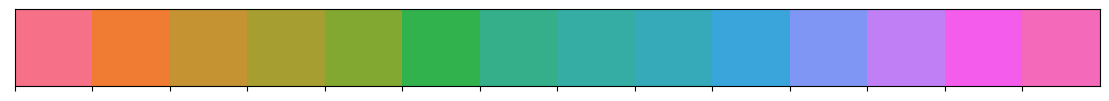

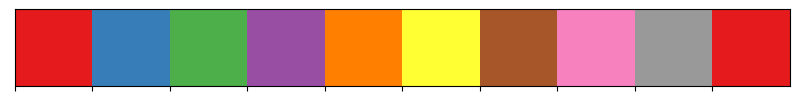

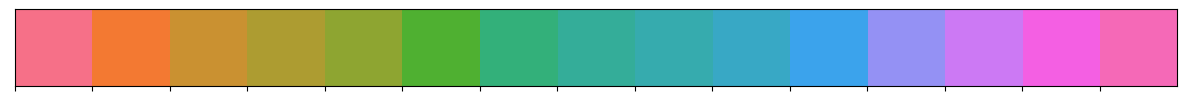

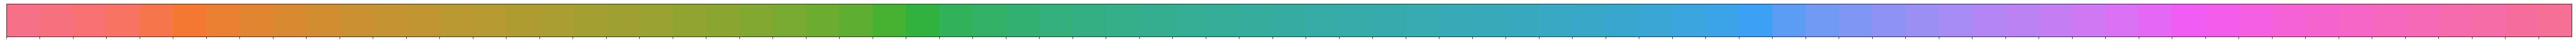

In [12]:
# Set microbe (column) colors
df = agora_tax_df.fillna('')
c = ['phylum', 'gram', 'oxygenstat', 'metabolism']
p = ['husl', 'Set1', 'husl', 'husl']
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
col_colors = [[palettes[i][df.loc[x, c[i]]] for x in df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

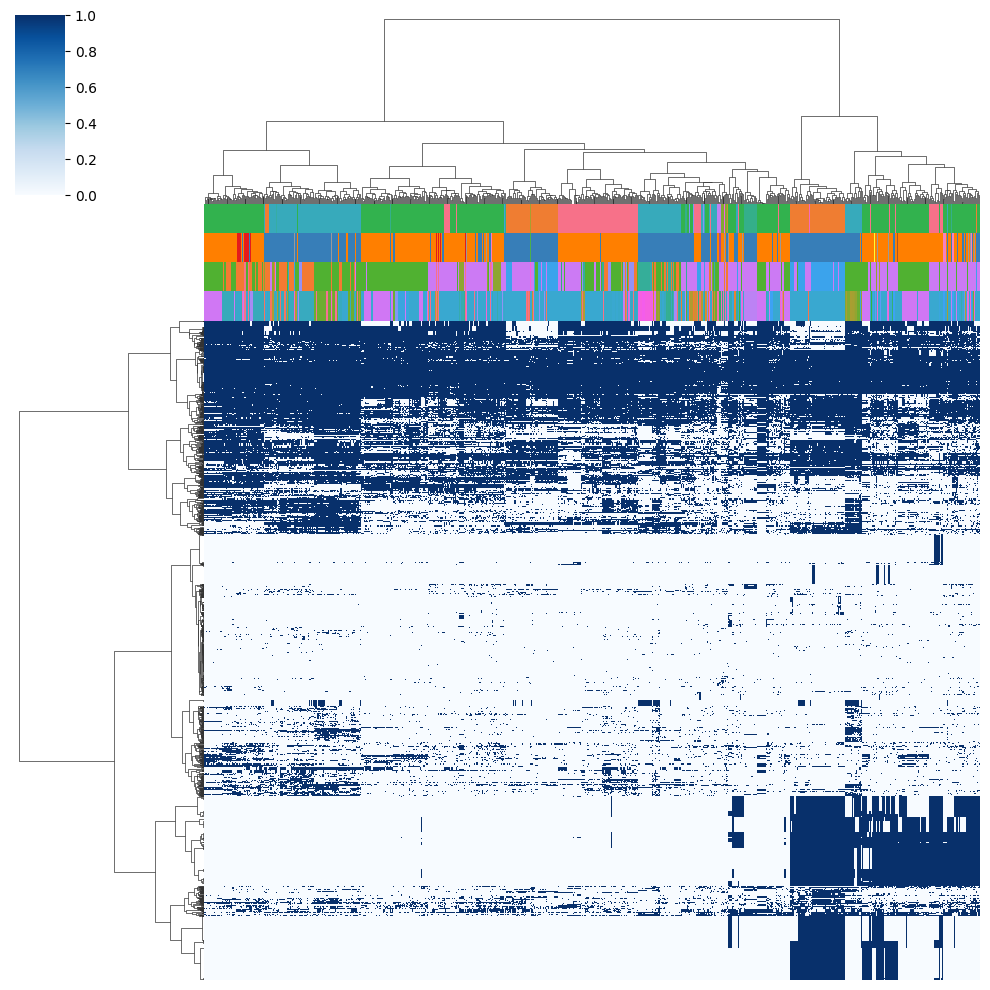

In [13]:
g = sns.clustermap(rxn_df, cmap='Blues', method='ward', xticklabels=False, yticklabels=False, col_colors=col_colors)
g.savefig(join(plot_dir, 'clustermap_agora.png'), bbox_inches='tight')

In [14]:
# Choose suffix indicating whose data is used ("marwa" or "pabo")
suffix = 'marwa'

In [15]:
# Load sample data
df = pd.read_csv(data_dir + '/metadata_table_' + suffix + '.csv', index_col=0)
df.columns = [x.lower() for x in df.columns]
sample_df = df.loc[:, df.isna().sum() < 95]
sample_df

,sample.name,sample.no,sample_type,phase,region,regime,sample_regime
M-T1-Rep1,1_1_1_1,1,intestine,stimulus,whole,M,intestine.M
M-T1-Rep2,1_1_1_2,7,intestine,stimulus,whole,M,intestine.M
M-T1-Rep3,1_1_1_3,235,intestine,stimulus,whole,M,intestine.M
M-T1-Rep4,1_1_1_4,19,intestine,stimulus,whole,M,intestine.M
M-T1-Rep5,1_1_1_5,215,intestine,stimulus,whole,M,intestine.M
...,...,...,...,...,...,...,...
VMV-T8-Rep1,3_8_1_D,95,intestine,challenge,distal,VMV,intestine.VMV
VMV-T8-Rep2,3_8_2_D,18,intestine,challenge,distal,VMV,intestine.VMV
VMV-T8-Rep3,3_8_3_D,244,intestine,challenge,distal,VMV,intestine.VMV
VMV-T8-Rep4,3_8_4_D,30,intestine,challenge,distal,VMV,intestine.VMV


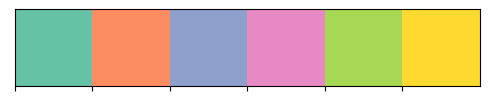

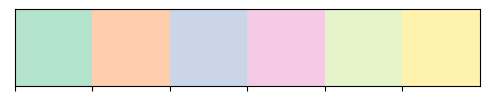

In [16]:
# Define regime order and palette
regime_order = {
    'marwa': ['M', 'V', 'MM', 'VM', 'MMV', 'VMV']
}
regime_palette = sns.color_palette('Set2', len(regime_order[suffix]))
regime_palette_pale = sns.color_palette('Pastel2', len(regime_order[suffix]))
sns.palplot(regime_palette)
sns.palplot(regime_palette_pale)

In [17]:
# Get digesta samples
intestine = sample_df.sample_type == 'intestine'
intestine

M-T1-Rep1      True
M-T1-Rep2      True
M-T1-Rep3      True
M-T1-Rep4      True
M-T1-Rep5      True
               ... 
VMV-T8-Rep1    True
VMV-T8-Rep2    True
VMV-T8-Rep3    True
VMV-T8-Rep4    True
VMV-T8-Rep6    True
Name: sample_type, Length: 105, dtype: bool

In [18]:
# Load taxonomy data
df = pd.read_csv(data_dir + '/tax_table_' + suffix + '.csv', index_col=0)
df.columns = [x.lower() for x in df.columns]
tax_df = df
tax_df

,kingdom,phylum,class,order,family,genus,species
TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,NaN,NaN
TGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCGTGCAGGAAGAAGGCCTTCGGGTTGTAAACTGCTTTAGTCTAGGAAAAAGGGGTGCGAGGTTAATACCCTCGTGCTTTGATGGTACTGGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTCTTGTAAGACAGTCGTGAAATCCCTGGGCTTAACCTAGGAACTGCGATTGTGACTGCAAGGCTAGAGTGTGTCAGAGGGGGGTGGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAACACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Sutterellaceae,AAP99,NaN
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTACCCGGGATGATAATGACAGTACCGGGAGAATAAGCTCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGTTATTCAAGTCAGAGGTGAAAGCCCGGGGCTCAACCCCGGAACTGCCTTTGAAACTAGATAGCTAGAATCTTGGAGAGGTCAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACTGACTGGACAAGTATTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Novosphingobium,NaN
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCAACGCCGCGTGAACGATGAAGGTCTTCGGATCGTAAAGTTCTGTCGCAGGGGAAGATAATGACGGTACCCTGTGAGGAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGTTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGTGGTCTTTCAAGTCGGTGGTTAAAGGCTACGGCTCAACCGTATTAAGCCGCCGAAACTGGAAGACTTGAGTGCAGGAGAGGAAAGTGGAATTCTCAGTGTAGCGGTGAAATGCGTAGATATTGAGAAGAACACCAGTAGCGAAGGCGGCTTTCTGGACTGTAACTGACACTGAGGCACGAAAGCGTGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Peptostreptococcales-Tissierellales,Peptostreptococcaceae,Peptostreptococcus,NaN
TGGGGAATATTGCGCAATGGGGGGAACCCTGACGCAGCCATGCCGCGTGAATGAAGAAGGCCTTCGGGTTGTAAAGTTCTTTCGGTATTGAGGAAGGTTGGTGTGTTAATAGCACATCAAATTGACGTTAAATACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGGCTTTTAAGTGAGGTGTGAAATCCCCGGGCTTAACCTGGGAATTGCATTTCAGACTGGGAGTCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGAAGGCGAAGGCAGCCCCTTGGGAATGTACTGACGCTCATGTGCGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Aggregatibacter,NaN
...,...,...,...,...,...,...,...
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCGTGAGTGATGAAAGTCTTCGGATTGTAAAACTCTGTTGTTAGGGAAGAACAAGTACCGTTCAAATAGGGCGGTACCTTGACGGTACCTAACCAGAAAGCTCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCGCGCAGGCGGTCTTCTAAGTCTGATGTGAAATCCCACGGCTTAACCGTGGAAGGTCATTGGAAACTGGAGGACTTGAGTGCAGAAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGAGATATGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGCAACTGACGCTGAGGCGCGAAAGCGTGGGTAGCGAACA,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Cerasibacillus,NaN
TGGGGAATCTTAGACAATGGGGGCAACCCTGATCTAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTCAGCTGGGAAGATAATGACGGTACCAGCAGAAGAAGCCCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGACCGGAAAGTCAGAGGTGAAATCCCAGGGCTCAACCTTGGAACTGCCTTTGAAACTATCGGTCTGGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Paracoccus,NaN
TGGGGAATATTGCGCAATGGGGGAAACCCTGACGCAGCAACGCCGCGTGAGCGATGAAGGTCTTCGGATTGTAAAGCTCTGTCTTTAGGGACGATAATGACGGTACCTAAGGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGAGTATGTAGGCGGATATTTAAGTCAGATGTGAAATTCCCGGGCTTAACCTGGGCGCTGCATTTGATACTGGATATCTAGAGTGTGGGAGAGGAAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAACACCAGTGGCGAAGGCGGCTTTCTGGACCATAACTGACGCTGAGATACGAAAGCGTGGGGAACAA

In [19]:
# Load count data
df = pd.read_csv(data_dir + '/count_table_' + suffix + '.csv', index_col=0)
cnt_df = df
cnt_df

,TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,TGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCGTGCAGGAAGAAGGCCTTCGGGTTGTAAACTGCTTTAGTCTAGGAAAAAGGGGTGCGAGGTTAATACCCTCGTGCTTTGATGGTACTGGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTCTTGTAAGACAGTCGTGAAATCCCTGGGCTTAACCTAGGAACTGCGATTGTGACTGCAAGGCTAGAGTGTGTCAGAGGGGGGTGGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAACACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTACCCGGGATGATAATGACAGTACCGGGAGAATAAGCTCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGTTATTCAAGTCAGAGGTGAAAGCCCGGGGCTCAACCCCGGAACTGCCTTTGAAACTAGATAGCTAGAATCTTGGAGAGGTCAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACTGACTGGACAAGTATTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCAACGCCGCGTGAACGATGAAGGTCTTCGGATCGTAAAGTTCTGTCGCAGGGGAAGATAATGACGGTACCCTGTGAGGAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGTTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGTGGTCTTTCAAGTCGGTGGTTAAAGGCTACGGCTCAACCGTATTAAGCCGCCGAAACTGGAAGACTTGAGTGCAGGAGAGGAAAGTGGAATTCTCAGTGTAGCGGTGAAATGCGTAGATATTGAGAAGAACACCAGTAGCGAAGGCGGCTTTCTGGACTGTAACTGACACTGAGGCACGAAAGCGTGGGTAGCAAACA,TGGGGAATATTGCGCAATGGGGGGAACCCTGACGCAGCCATGCCGCGTGAATGAAGAAGGCCTTCGGGTTGTAAAGTTCTTTCGGTATTGAGGAAGGTTGGTGTGTTAATAGCACATCAAATTGACGTTAAATACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGGCTTTTAAGTGAGGTGTGAAATCCCCGGGCTTAACCTGGGAATTGCATTTCAGACTGGGAGTCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGAAGGCGAAGGCAGCCCCTTGGGAATGTACTGACGCTCATGTGCGAAAGCGTGGGGAGCAAACA,TGAGGAATCTTCCACAATGGGCGAAAGCCTGATGGAGCAACGCCGCGTGCAGGATGAAGGCCTTCGGGTCGTAAACTGCTTTTATAAGTGAAGAATATGACGGTAACTTATGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTCATACGTAGGGTGCAAGCATTATCCGGAGTGACTGGGCGTAAAGAGTTGCGTAGGTGGACAAATAAGCGAATAGTGAAATCTGGTGGCTCAACCACACAGACTATTATTCGAACTGTTTGTCTCGAGAATAGCAGAGGTAACTGGAATTTCTAGTGTAGGAGTGAAATCCGTAGATATTAGAAGGAACACCAATGGAGTAGGCAGGTTACTGGGCTATTTCTGACACTGAGGCACGAAAGCGTGGGGAGCGAACC,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTGTCCGGGACGATAATGACGGTACCGGAAGAATAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCGATTAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGGTTGGCTTGAGACCGGAAGAGGACAGCGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCCTGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGGCAATGGAGGAAACTCTGACCCAGCGACGCCGCGTGAGGGATGAAGGCCTTCGGGTTGTAAACCTCTTTCAGTAGGGAAGAAGCGAAAGTGACGGTACCTACAGAAGAAGCACCGGCTAACTATGTGCCAGCAGCCGCGGTAATACATAGGGTGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGTGGTTAGATACGTCGGATGTGAAAATCAGGGGCTCAACCCCTGACCTGCATTCGATACGGTCTAGCTAGAGTGTGGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCCATTACTGACACTGAGGAGCGAAAGCGTGGGGAGCGAACA,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCCTAGGGTTGTAAAGCTCTTTCACCGGTGAAGATAATGACGGTAACCGGAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGACTTTTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTTTGATACTGGAAGTCTTGAGTATGGTAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGACCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCAATGCCGCGTGGATGAAGAAGGTCTTCGGATTGTAAAGTCCTTTCGGCGGGGACGATGATGACGGTACCCGCAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGCTCGGAATGACTGGGCGTAAAGGGCGCGTAGGCGGATTGCTTAGTCAGGCGTGAAAGTCCTGGGCTCAACCTGGGGATTGCGCTTGATACGGGTGGTCTAGAGTTGGAAAGAGGGTCGTGGAATTCCCAGTGTAGAGGTGAAATT

Text(0.5, 0, 'Abundance (log10)')

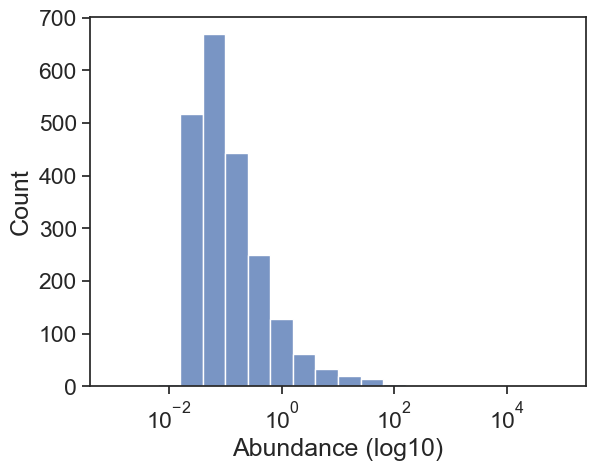

In [20]:
sns.set(style='ticks', font_scale=1.5)
sns.histplot(cnt_df.mean(), bins=20, binrange=(-3, 5), log_scale=True)
plt.xlabel('Abundance (log10)')

In [21]:
# Normalize counts to fraction
frac_df = cnt_df.T / cnt_df.sum(1)
frac_df = frac_df.T
frac_df

,TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,TGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCGTGCAGGAAGAAGGCCTTCGGGTTGTAAACTGCTTTAGTCTAGGAAAAAGGGGTGCGAGGTTAATACCCTCGTGCTTTGATGGTACTGGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTCTTGTAAGACAGTCGTGAAATCCCTGGGCTTAACCTAGGAACTGCGATTGTGACTGCAAGGCTAGAGTGTGTCAGAGGGGGGTGGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAACACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTACCCGGGATGATAATGACAGTACCGGGAGAATAAGCTCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGTTATTCAAGTCAGAGGTGAAAGCCCGGGGCTCAACCCCGGAACTGCCTTTGAAACTAGATAGCTAGAATCTTGGAGAGGTCAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACTGACTGGACAAGTATTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCAACGCCGCGTGAACGATGAAGGTCTTCGGATCGTAAAGTTCTGTCGCAGGGGAAGATAATGACGGTACCCTGTGAGGAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGTTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGTGGTCTTTCAAGTCGGTGGTTAAAGGCTACGGCTCAACCGTATTAAGCCGCCGAAACTGGAAGACTTGAGTGCAGGAGAGGAAAGTGGAATTCTCAGTGTAGCGGTGAAATGCGTAGATATTGAGAAGAACACCAGTAGCGAAGGCGGCTTTCTGGACTGTAACTGACACTGAGGCACGAAAGCGTGGGTAGCAAACA,TGGGGAATATTGCGCAATGGGGGGAACCCTGACGCAGCCATGCCGCGTGAATGAAGAAGGCCTTCGGGTTGTAAAGTTCTTTCGGTATTGAGGAAGGTTGGTGTGTTAATAGCACATCAAATTGACGTTAAATACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGGCTTTTAAGTGAGGTGTGAAATCCCCGGGCTTAACCTGGGAATTGCATTTCAGACTGGGAGTCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGAAGGCGAAGGCAGCCCCTTGGGAATGTACTGACGCTCATGTGCGAAAGCGTGGGGAGCAAACA,TGAGGAATCTTCCACAATGGGCGAAAGCCTGATGGAGCAACGCCGCGTGCAGGATGAAGGCCTTCGGGTCGTAAACTGCTTTTATAAGTGAAGAATATGACGGTAACTTATGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTCATACGTAGGGTGCAAGCATTATCCGGAGTGACTGGGCGTAAAGAGTTGCGTAGGTGGACAAATAAGCGAATAGTGAAATCTGGTGGCTCAACCACACAGACTATTATTCGAACTGTTTGTCTCGAGAATAGCAGAGGTAACTGGAATTTCTAGTGTAGGAGTGAAATCCGTAGATATTAGAAGGAACACCAATGGAGTAGGCAGGTTACTGGGCTATTTCTGACACTGAGGCACGAAAGCGTGGGGAGCGAACC,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTGTCCGGGACGATAATGACGGTACCGGAAGAATAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGCTCGGAATCACTGGGCGTAAAGGGCGCGTAGGCGGCCGATTAAGTCGGGGGTGAAAGCCTGTGGCTCAACCACAGAATTGCCTTCGATACTGGTTGGCTTGAGACCGGAAGAGGACAGCGGAACTGCGAGTGTAGAGGTGAAATTCGTAGATATTCGCAAGAACACCAGTGGCGAAGGCGGCTGTCTGGTCCTGTTCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGGCAATGGAGGAAACTCTGACCCAGCGACGCCGCGTGAGGGATGAAGGCCTTCGGGTTGTAAACCTCTTTCAGTAGGGAAGAAGCGAAAGTGACGGTACCTACAGAAGAAGCACCGGCTAACTATGTGCCAGCAGCCGCGGTAATACATAGGGTGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGAGCTCGTAGGTGGTTAGATACGTCGGATGTGAAAATCAGGGGCTCAACCCCTGACCTGCATTCGATACGGTCTAGCTAGAGTGTGGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGGAATGCGCAGATATCAGGAGGAACACCGATGGCGAAGGCAGGTCTCTGGGCCATTACTGACACTGAGGAGCGAAAGCGTGGGGAGCGAACA,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCCTAGGGTTGTAAAGCTCTTTCACCGGTGAAGATAATGACGGTAACCGGAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGACTTTTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTTTGATACTGGAAGTCTTGAGTATGGTAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGACCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCAATGCCGCGTGGATGAAGAAGGTCTTCGGATTGTAAAGTCCTTTCGGCGGGGACGATGATGACGGTACCCGCAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGCTCGGAATGACTGGGCGTAAAGGGCGCGTAGGCGGATTGCTTAGTCAGGCGTGAAAGTCCTGGGCTCAACCTGGGGATTGCGCTTGATACGGGTGGTCTAGAGTTGGAAAGAGGGTCGTGGAATTCCCAGTGTAGAGGTGAAATT

Text(0.5, 0, 'Fraction (log10)')

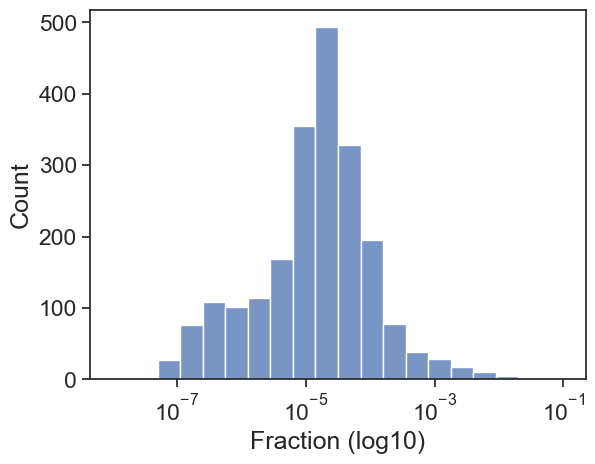

In [22]:
sns.set(style='ticks', font_scale=1.5)
sns.histplot(frac_df.mean(), bins=20, binrange=(-8, -1), log_scale=True)
plt.xlabel('Fraction (log10)')

Text(0, 0.5, 'Fraction (log10)')

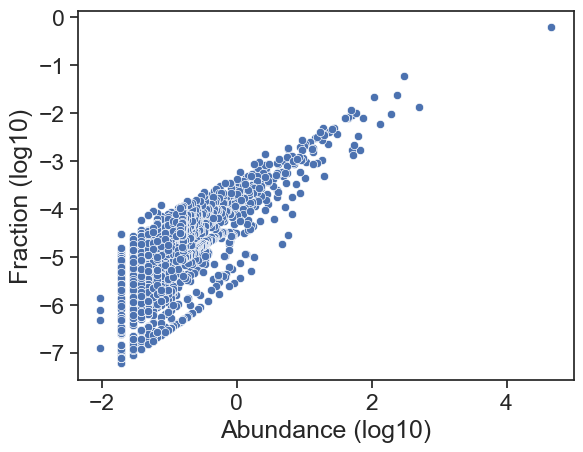

In [23]:
sns.set(style='ticks', font_scale=1.5)
sns.scatterplot(x=np.log10(cnt_df.mean()), y=np.log10(frac_df.mean()))
plt.xlabel('Abundance (log10)')
plt.ylabel('Fraction (log10)')

In [24]:
sample_df.nunique()

sample.name      105
sample.no        105
sample_type        1
phase              3
region             2
regime             6
sample_regime      6
dtype: int64

In [25]:
tax_df.nunique()

kingdom      1
phylum      20
class       40
order      116
family     240
genus      452
species    222
dtype: int64

In [26]:
# Choose sample variables and palettes
c = ['regime', 'phase']
p = ['husl', 'Blues']

['Acidobacteriota', 'Actinobacteriota', 'Armatimonadota', 'Bacteroidota', 'Bdellovibrionota', 'Campilobacterota', 'Chloroflexi', 'Deinococcota', 'Dependentiae', 'Fibrobacterota', 'Firmicutes', 'Fusobacteriota', 'Gemmatimonadota', 'Myxococcota', 'Nitrospirota', 'Patescibacteria', 'Planctomycetota', 'Proteobacteria', 'Spirochaetota', 'Verrucomicrobiota']
['M', 'MM', 'MMV', 'V', 'VM', 'VMV']
['challenge', 'intermediate', 'stimulus']


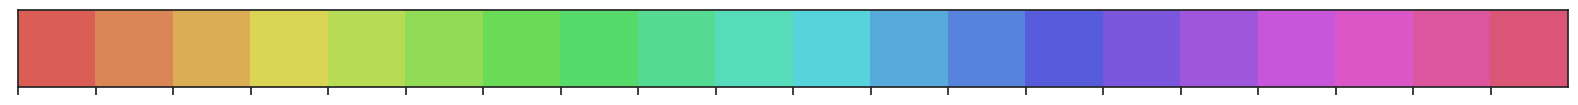

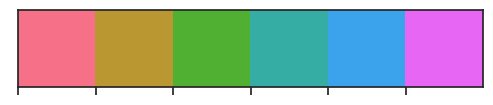

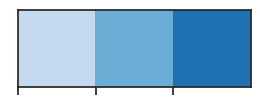

In [27]:
# Set microbe (column) colors
df = tax_df.fillna('')
rank = 'phylum'
palette = dict(zip(sorted(set(df[rank])), sns.color_palette('hls', len(set(df[rank])))))
col_colors = [palette[df.loc[x, rank]] for x in frac_df.columns]

sns.palplot(palette.values())
print(sorted(set(df[rank])))

# Set sample (row) colors
df = sample_df.fillna(0)
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
row_colors = [[palettes[i][df.loc[x, c[i]]] for x in frac_df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

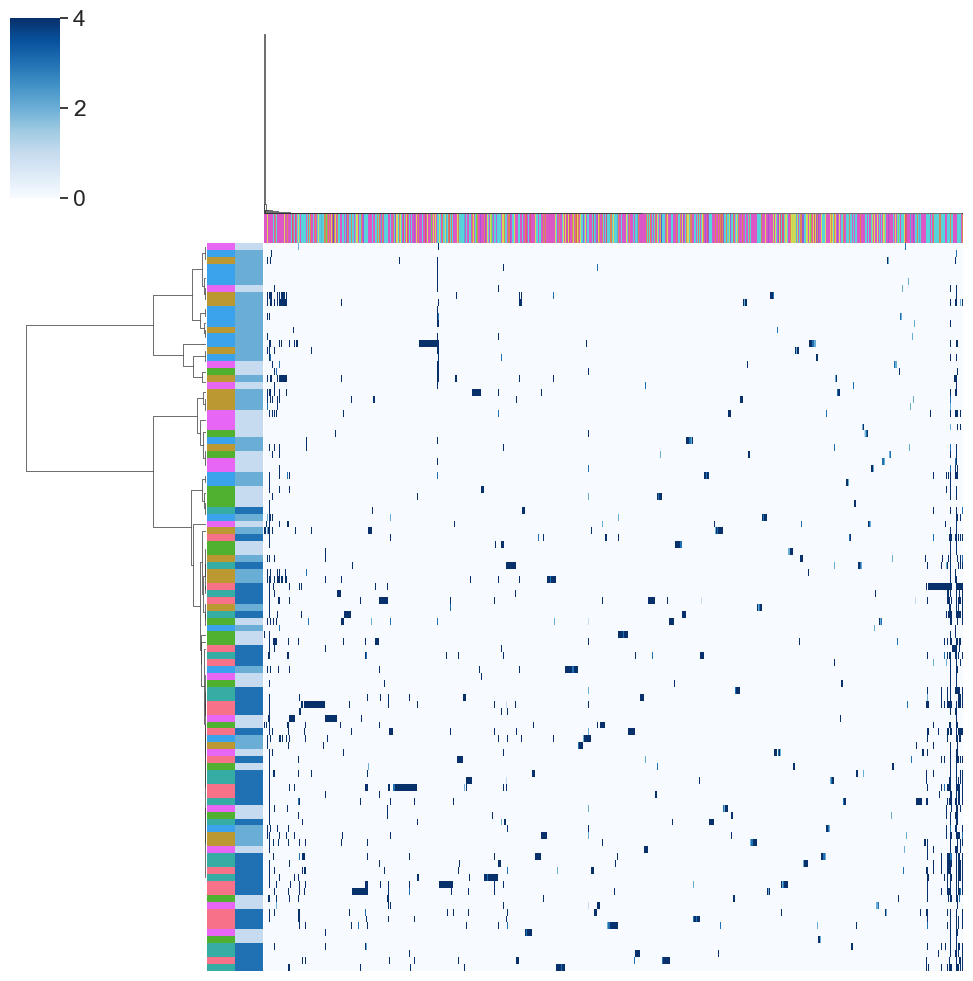

In [28]:
# Clustermap (counts)
g = sns.clustermap(cnt_df, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_cnt_' + suffix + '.png'), bbox_inches='tight')

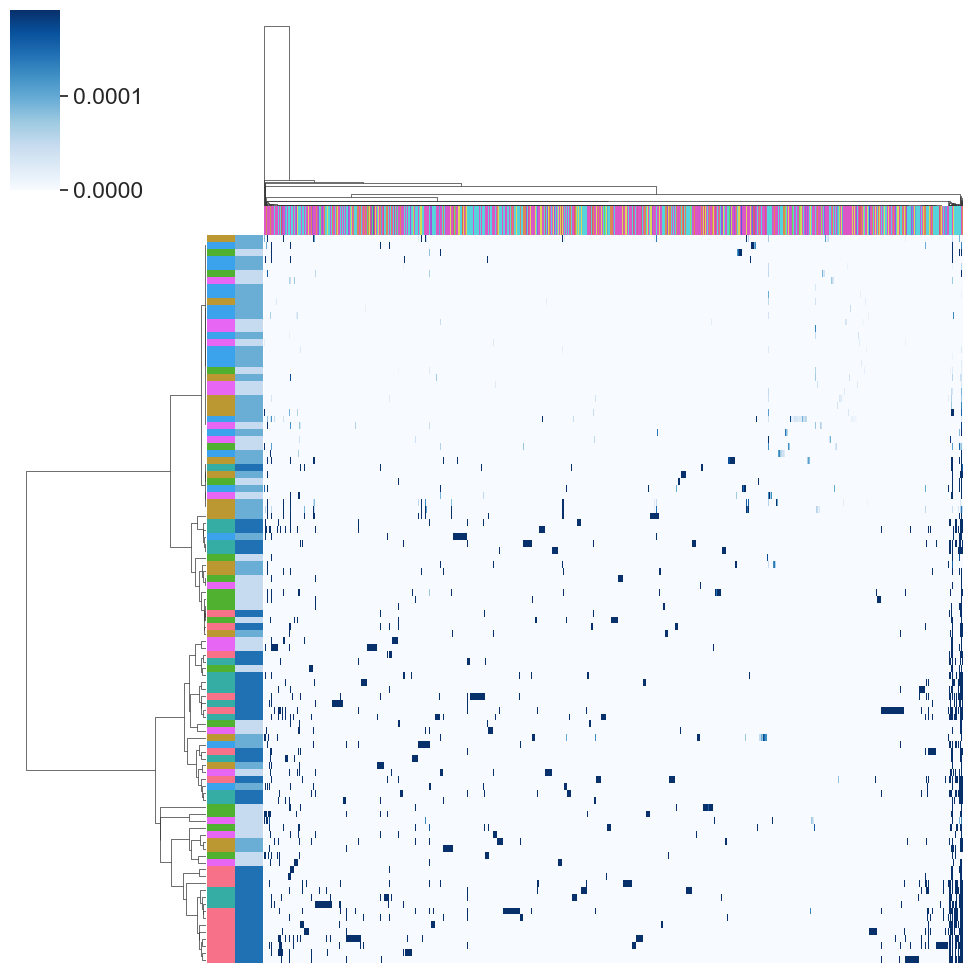

In [29]:
# Clustermap (fractions)
g = sns.clustermap(frac_df, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_frac_' + suffix + '.png'), bbox_inches='tight')

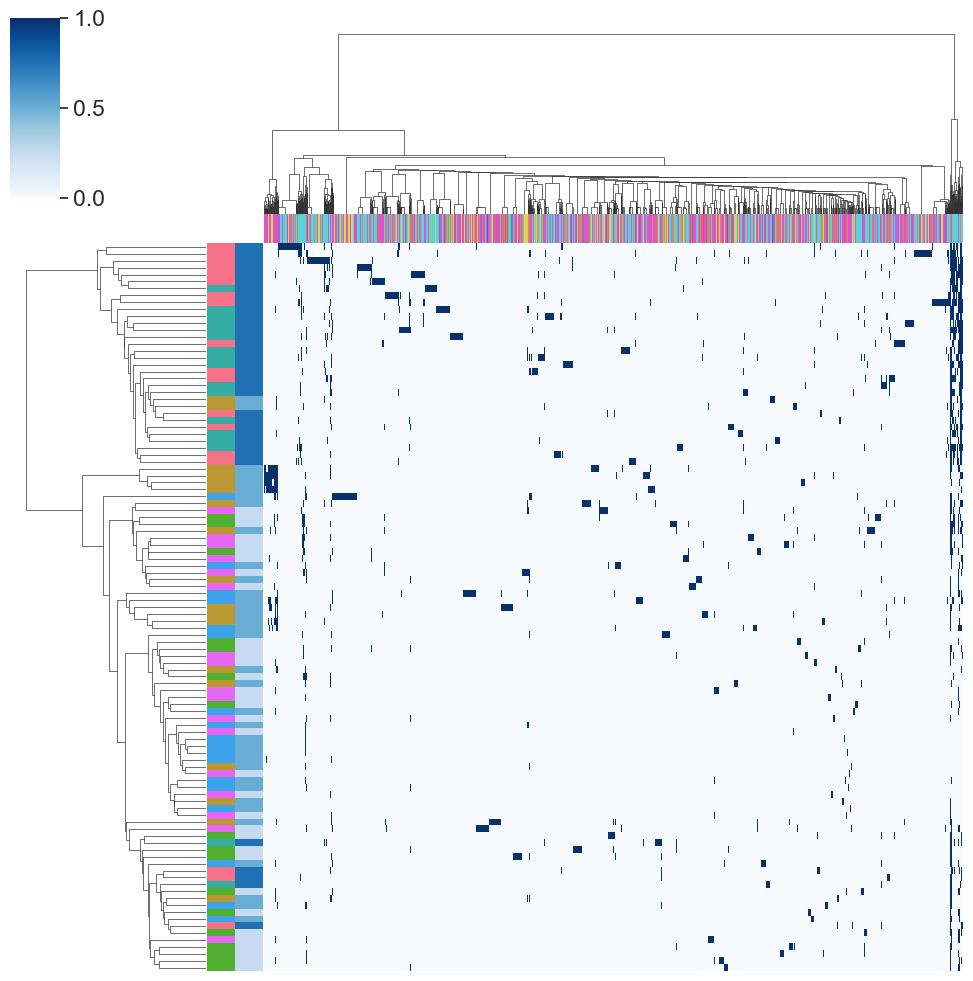

In [30]:
# Clustermap (binary)
g = sns.clustermap(frac_df > 0, cmap='Blues', method='ward', robust=True, row_colors=row_colors, col_colors=col_colors, yticklabels=False, xticklabels=False)
g.savefig(join(plot_dir, 'clustermap_bin_' + suffix + '.png'), bbox_inches='tight')

In [31]:
# PCA on counts
pca = PCA()
Z = StandardScaler().fit_transform(frac_df[intestine])
T = pca.fit_transform(Z)
T.shape

(105, 105)

In [32]:
n = 5
sample_df.loc[intestine, ['pc' + str(x + 1) for x in range(n)]] = T[:, :n]
sample_df

,sample.name,sample.no,sample_type,phase,region,regime,sample_regime,pc1,pc2,pc3,pc4,pc5
M-T1-Rep1,1_1_1_1,1,intestine,stimulus,whole,M,intestine.M,0.623482,-1.582713,-0.154001,-1.050428,0.088144
M-T1-Rep2,1_1_1_2,7,intestine,stimulus,whole,M,intestine.M,0.062507,-1.176446,-0.600801,-1.505157,-0.303175
M-T1-Rep3,1_1_1_3,235,intestine,stimulus,whole,M,intestine.M,-9.445311,1.053302,6.692990,55.715069,-42.578585
M-T1-Rep4,1_1_1_4,19,intestine,stimulus,whole,M,intestine.M,-1.437108,-1.409358,-0.503353,3.888375,0.544944
M-T1-Rep5,1_1_1_5,215,intestine,stimulus,whole,M,intestine.M,-2.420169,-0.839931,2.048330,5.798641,4.034713
...,...,...,...,...,...,...,...,...,...,...,...,...
VMV-T8-Rep1,3_8_1_D,95,intestine,challenge,distal,VMV,intestine.VMV,1.667764,-1.569872,-0.770875,-1.595614,-0.360368
VMV-T8-Rep2,3_8_2_D,18,intestine,challenge,distal,VMV,intestine.VMV,1.197662,-1.278337,-0.923360,-1.528805,-0.374943
VMV-T8-Rep3,3_8_3_D,244,intestine,challenge,distal,VMV,intestine.VMV,1.695914,-1.420928,-0.731005,-1.530171,-0.344364
VMV-T8-Rep4,3_8_4_D,30,intestine,challenge,distal,VMV,intestine.VMV,1.595878,-1.550028,-0.748991,-1.538701,-0.345651


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


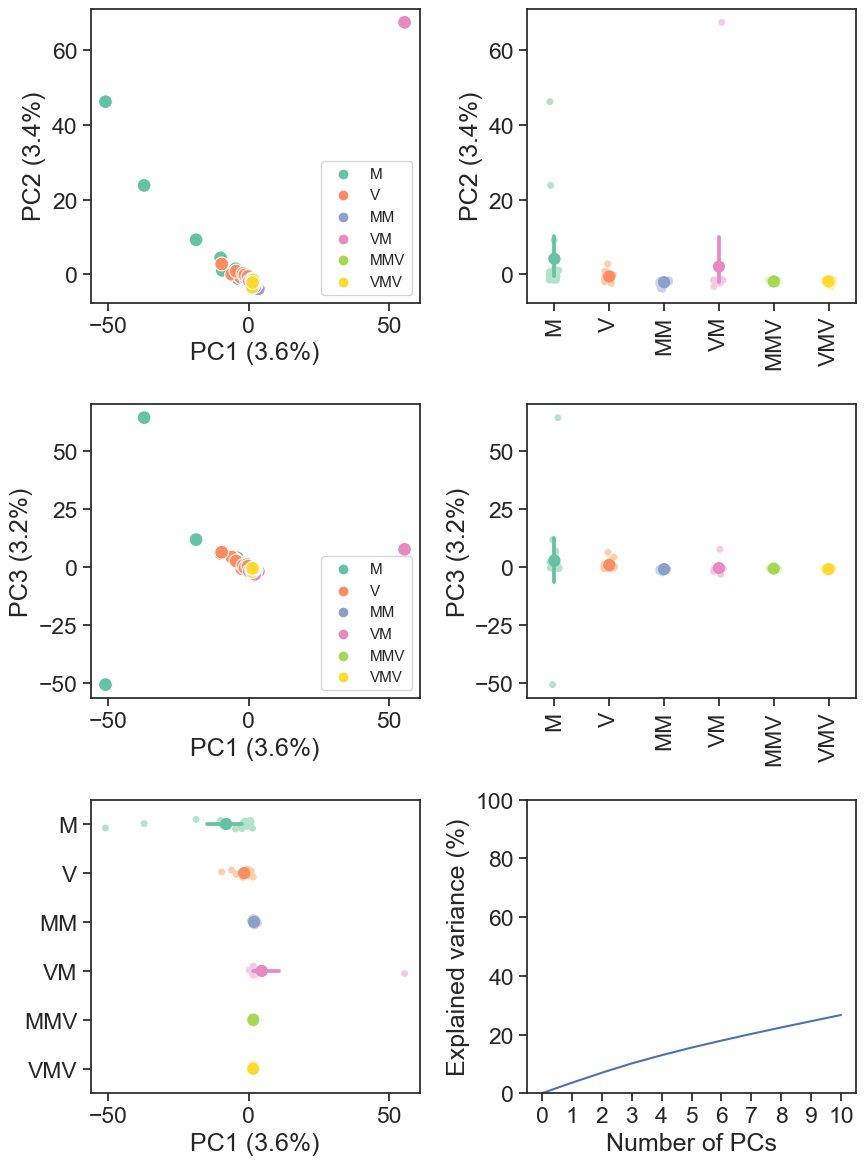

In [33]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = sample_df[intestine]
order = regime_order[suffix]

plt.subplot(3, 2, 1)
ax = sns.scatterplot(x=df.pc1, y=df.pc2, hue=df.regime, hue_order=order, palette=regime_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
# ax.legend().set_visible(False)
ax.legend(ncol=1, fontsize=11, loc='lower right').set_title(None)

plt.subplot(3, 2, 2)
ax = sns.pointplot(x=df.regime, y=df.pc2, join=False, palette=regime_palette, orient='v', order=order)
ax = sns.stripplot(x=df.regime, y=df.pc2, palette=regime_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('')
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend().set_visible(False)

plt.subplot(3, 2, 3)
ax = sns.scatterplot(x=df.pc1, y=df.pc3, hue=df.regime, hue_order=order, palette=regime_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
# ax.legend().set_visible(False)
ax.legend(ncol=1, fontsize=11, loc='lower right').set_title(None)

plt.subplot(3, 2, 4)
ax = sns.pointplot(x=df.regime, y=df.pc3, join=False, palette=regime_palette, orient='v', order=order)
ax = sns.stripplot(x=df.regime, y=df.pc3, palette=regime_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_yticklabels([])

plt.subplot(3, 2, 5)
ax = sns.pointplot(y=df.regime, x=df.pc1, join=False, palette=regime_palette, orient='h', order=order)
ax = sns.stripplot(y=df.regime, x=df.pc1, palette=regime_palette_pale, zorder=-1, orient='h', order=order)
plt.ylabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))

plt.subplot(3, 2, 6)
n = 10
x = [0]
x.extend(range(1, n + 1))
y = [0]
y.extend(100 * np.cumsum(pca.explained_variance_ratio_[:n]))
ax = sns.lineplot(x=x, y=y)
plt.ylim(0, 100)
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance (%)')
ax.set_xticks(range(n + 1))
ax.set_xticklabels(range(n + 1))


f.set_size_inches(9, 12)
plt.tight_layout()
f.savefig(join(plot_dir, 'pca_cnt_' + suffix + '.tiff'), bbox_inches='tight')

In [34]:
# Map samples to models (fast)

mapping = {}
matches = []
models = []

for i, row in tax_df.iterrows():
    if row.family == np.nan or row.family not in set(agora_tax_df.family):
        matches.append(np.nan)
        models.append(0)
        continue
    
    df = agora_tax_df[agora_tax_df.family == row.family]
    m = 'family'
    for rank in ('genus', 'species'):
        if row[rank] in set(df[rank]):
            df = df[df[rank] == row[rank]]
            m = rank
    
    mapping[row.name] = list(df.index)
    matches.append(m.capitalize())
    models.append(len(df))

tax_df['match'] = matches
tax_df['models'] = models
tax_df

,kingdom,phylum,class,order,family,genus,species,match,models
TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,NaN,NaN,Family,28
TGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCGTGCAGGAAGAAGGCCTTCGGGTTGTAAACTGCTTTAGTCTAGGAAAAAGGGGTGCGAGGTTAATACCCTCGTGCTTTGATGGTACTGGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTCTTGTAAGACAGTCGTGAAATCCCTGGGCTTAACCTAGGAACTGCGATTGTGACTGCAAGGCTAGAGTGTGTCAGAGGGGGGTGGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAACACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Sutterellaceae,AAP99,NaN,Family,1
TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTACCCGGGATGATAATGACAGTACCGGGAGAATAAGCTCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGTTATTCAAGTCAGAGGTGAAAGCCCGGGGCTCAACCCCGGAACTGCCTTTGAAACTAGATAGCTAGAATCTTGGAGAGGTCAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACTGACTGGACAAGTATTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Novosphingobium,NaN,Family,1
TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCAACGCCGCGTGAACGATGAAGGTCTTCGGATCGTAAAGTTCTGTCGCAGGGGAAGATAATGACGGTACCCTGTGAGGAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGTTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGTGGTCTTTCAAGTCGGTGGTTAAAGGCTACGGCTCAACCGTATTAAGCCGCCGAAACTGGAAGACTTGAGTGCAGGAGAGGAAAGTGGAATTCTCAGTGTAGCGGTGAAATGCGTAGATATTGAGAAGAACACCAGTAGCGAAGGCGGCTTTCTGGACTGTAACTGACACTGAGGCACGAAAGCGTGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Peptostreptococcales-Tissierellales,Peptostreptococcaceae,Peptostreptococcus,NaN,Genus,2
TGGGGAATATTGCGCAATGGGGGGAACCCTGACGCAGCCATGCCGCGTGAATGAAGAAGGCCTTCGGGTTGTAAAGTTCTTTCGGTATTGAGGAAGGTTGGTGTGTTAATAGCACATCAAATTGACGTTAAATACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGGCTTTTAAGTGAGGTGTGAAATCCCCGGGCTTAACCTGGGAATTGCATTTCAGACTGGGAGTCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGAAGGCGAAGGCAGCCCCTTGGGAATGTACTGACGCTCATGTGCGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Pasteurellales,Pasteurellaceae,Aggregatibacter,NaN,Genus,1
...,...,...,...,...,...,...,...,...,...
TAGGGAATCTTCCGCAATGGACGCAAGTCTGACGGAGCAACGCCGCGTGAGTGATGAAAGTCTTCGGATTGTAAAACTCTGTTGTTAGGGAAGAACAAGTACCGTTCAAATAGGGCGGTACCTTGACGGTACCTAACCAGAAAGCTCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGGGCGCGCAGGCGGTCTTCTAAGTCTGATGTGAAATCCCACGGCTTAACCGTGGAAGGTCATTGGAAACTGGAGGACTTGAGTGCAGAAGAGGAGAGTGGAATTCCATGTGTAGCGGTGAAATGCGTAGAGATATGGAGGAACACCAGTGGCGAAGGCGACTCTCTGGTCTGCAACTGACGCTGAGGCGCGAAAGCGTGGGTAGCGAACA,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae,Cerasibacillus,NaN,Family,29
TGGGGAATCTTAGACAATGGGGGCAACCCTGATCTAGCCATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTCAGCTGGGAAGATAATGACGGTACCAGCAGAAGAAGCCCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGTAGGCGGACCGGAAAGTCAGAGGTGAAATCCCAGGGCTCAACCTTGGAACTGCCTTTGAAACTATCGGTCTGGAGTTCGAGAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGCTCGATACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodobacterales,Rhodobacteraceae,Paracoccus,NaN,Genus,1
TGGGGAATATTGCGCAATGGGGGAAACCCTGACGCAGCAACGCCGCGTGAGCGATGAAGGTCTTCGGATTGTAAAGCTCTGTCTTTAGGGACGATAATGACGGTACCTAAGGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGAGTATGTAGGCGGATATTTAAGTCAGATGTGAAATTCCCGGGCTTAACCTGGGCGCTGCATTTGATACTGGATATCTAGAGTGTGGGAGAGGAAAGCGGAATTCCTAGTGTAGCGGTGAAATG

In [35]:
sns.set(font_scale=1.5, style='ticks')
df = tax_df
df = df.sort_values(by='match')
df

,kingdom,phylum,class,order,family,genus,species,match,models
TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,Bacteria,Firmicutes,Clostridia,Oscillospirales,Ruminococcaceae,NaN,NaN,Family,28
TGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATACCGCGTGCGGGAAGAAGGCCTTCGGGTTGTAAACCGCTTTTGTCAGGGAAGAAATACTCTGGGCTAATACCCTGGGGTGATGACGGTACCTGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTTCTATAAGACAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATTTGTGACTGTAGAGCTAGAGTACGGTAGAGGGGGATGGAATTCCGCGTGTAGCAGTGAAATGCGTAGATATGCGGAGGAACACCGATGGCGAAGGCAATCCCCTGGACCTGTACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Burkholderiales,Comamonadaceae,Sphaerotilus,NaN,Family,2
TGGGGAATATTGGACAATGGACCAAAAGTCTGATCCAGCAATTCTGTGTGCACGATGAAGGTCTTCGGATTGTAAAGTGCTTTCAGGTGGGAAGAAGAAAGTGACGGTACCACCAGAAGAAGCGACGGCTAAATACGTGCCAGCAGCCGCGGTAATACGTATGTCGCAAGCGTTATCCGGAATTATTGGGCGTAAAGCGAGTCTAGGCGGCTTGTTAAGTCAGATGTGAAAATGCGGGGCTCAACTCCGTATTGCGTTTGAAACTGGCAGGCTAGAGTACTGGAGAGGTGGGCGGAACTACAAGTGTAGAGGTGAAATTCGTAGATATTTGTAGGAATGCCGATAGTGAAGACAGCTCACTGGACAGATACTGACGCTAAAGCTCGAAAGCGTGGGGAGCTAACA,Bacteria,Fusobacteriota,Fusobacteriia,Fusobacteriales,Fusobacteriaceae,Psychrilyobacter,NaN,Family,18
TGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCCATGCCGCGTGTATGAAGAAGGCCTTCGGGTTGTAAAGTACTTTCAGTTGTGAGGAAGGCGTTGGAGTTAATAGCTTCAGCGTTTGACGTTAGCAACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGCGGTCTGTTAAGCAAGATGTGAAAGCCCGGGGCTCAACCTCGGAACAGCATTTTGAACTGGCAGACTAGAGTCTTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAAAGACTGACACTCAGATGCGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,Photobacterium,NaN,Family,9
TGGGGAATATTGCGCAATGGGGGAAACCCTGACGCAGCAACGCCGCGTGAGCGATGAAGGTCTTCGGATTGTAAAGCTCTGTCTTTAGGGACGATAATGACGGTACCTAAGGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGCGTAAAGAGTATGTAGGCGGATATTTAAGTCAGATGTGAAATTCCCGGGCTTAACCTGGGCGCTGCATTTGATACTGGATATCTAGAGTGTGGGAGAGGAAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGAGATTAGGAAGAACACCAGTGGCGAAGGAGGCTTTCTGGACCATAACTGACGCTGAGATACGAAAGCGTGGGGAGCAAACA,Bacteria,Firmicutes,Clostridia,Clostridiales,Clostridiaceae,Clostridium sensu stricto 7,NaN,Family,24
...,...,...,...,...,...,...,...,...,...
TGGGGAATCTTGGACAATGGGGGAAACCCTGATCCAGCGATGCCGCGTGAGTGATGAAGGCCTTCGGGTTGTAAAGCTCTTTCGCCTACGAAGATAATGACGGTAGTAGGTAAAGAAGCCCCGGCTAACTCCGTGCCAGCAGCCGCGGTAAGACGGAGGGGGCTAGCGTTGTTCGGAATGACTGGGCGTAAAGGGCGCGTAGGCGGTCTTTCAAGTCAGGCGTGAAATCCTGGGGCTTAACCCCAGAACTGCGCTTGAGACTGGAAGGCTAGAGGATCAGAGAGGATGGTGGAATTCCAAGTGTAGAGGTGAAATTCGTAGATATTTGGAGGAACATCAGAGGCGAAGGCGGCCATCTGGCTGATATCTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,Bacteria,Proteobacteria,Alphaproteobacteria,Caedibacterales,Caedibacteraceae,Caedibacter,NaN,NaN,0
TAGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGAGGAAGGTCTTCGGATCGTAAAACTCTGTTGTCAGGGAAGAACCGCCGGGATGACCTCCCGGTCTGACGGTACCTGACGAGAAAGCCCCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGCTTCTTAAGTCAGGTGTGAAAGCCCACGGCTCAACCGTGGAGGGCCATCTGAAACTGGGGAGCTTGAGTGCAGGAGAGGAGAGCGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGGCTCTCTGGCCTGTAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,Bacteria,Firmicutes,Bacilli,Aneurinibacillales,Aneurinibacillaceae,Aneurinibacillus,thermoaerophilus,NaN,0
TAGGGAATATTGGGCAATGGACGAGAGTCTGACCCAGCCATGCCGCGTGCAGGAAGAAGGCTTTCTGAGTCGTAAACTGCTTTTGACAGGGAAGAATAAGCTGGTCGTGACCAGTGATGACGGTACCTGCAGAATAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTGTCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGCCTTATAAGTCCGGGGTGAAAGCCCGCTGCTCAACAGCGGAACTGCCCTGGATACTGTGAGGCTTGAGTACAGACGAGGTTGGCGGAATG

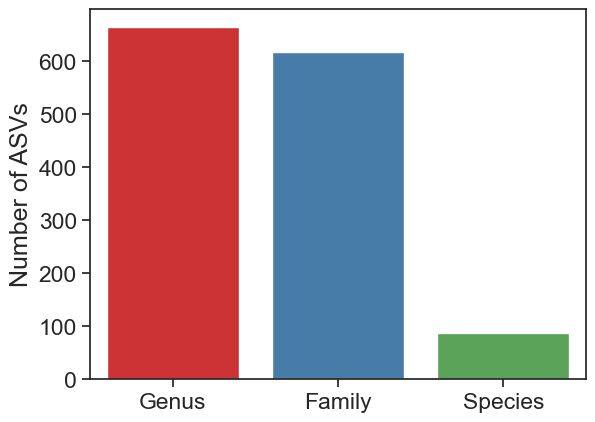

In [36]:
# Plot taxonomic level of match for each ASV
f = plt.figure()

counts = df['match'].value_counts()

ax = sns.barplot(x=counts.index, y=counts.values, palette='Set1')

plt.xlabel('Taxonomic level of model match')
plt.xlabel('')
plt.ylabel('Number of ASVs')

f.savefig(join(plot_dir, 'match_level_asv_' + suffix + '.tiff'), bbox_inches='tight')

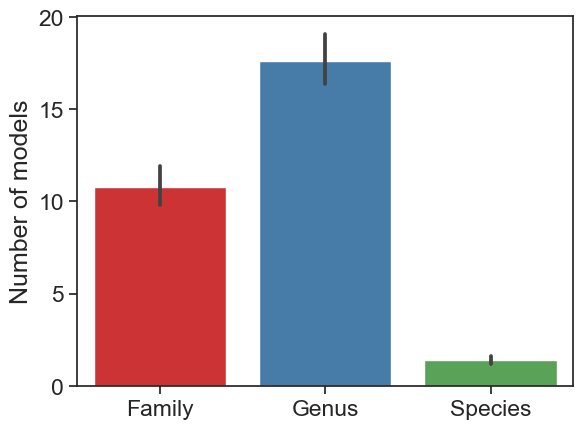

In [37]:
# Plot number of models mapped to each ASV by taxonomic level of match
f = plt.figure()

df = df[df.models > 0]
ax = sns.barplot(x=df.match, y=df.models, palette='Set1')

plt.xlabel('')
plt.ylabel('Number of models')

f.savefig(join(plot_dir, 'match_level_models_' + suffix + '.tiff'), bbox_inches='tight')

In [38]:
# Get fraction of models containing each reaction for each ASV
d = {}
for k, models in mapping.items():
    d[k] = rxn_df.iloc[:, models].mean(1)
asv_rxn_df = pd.DataFrame(d)
asv_rxn_df.to_csv(data_dir + '/asv_reactions_' + suffix + '.csv')
asv_rxn_df

,TAGGGAATATTGCACAATGGAGGAAACTCTGATGCAGCGACGTCGCGTGAGGGAAGAAGGTTTTCGGATTGTAAACCTCTGTCTTTGGTGAAGAAAATGACGGTAACCAAAGAGGAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGGGAATAAGTTGAATGTTAAAACTATCGGCTCAACCGATAGCAGCGTTCAAAACTATTTCTCTTGAGTGGAGTAGAGGTAAGCGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGTTTACTGGGCTCTAACTGACGCTGAGGCTCGAAAGCGTGGGTAGCAAACA,TGGGGAATTTTGGACAATGGGCGAAAGCCTGATCCAGCCATGCCGCGTGCAGGAAGAAGGCCTTCGGGTTGTAAACTGCTTTAGTCTAGGAAAAAGGGGTGCGAGGTTAATACCCTCGTGCTTTGATGGTACTGGAAGAATAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGTCTTGTAAGACAGTCGTGAAATCCCTGGGCTTAACCTAGGAACTGCGATTGTGACTGCAAGGCTAGAGTGTGTCAGAGGGGGGTGGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAACACCGATGGCGAAGGCAGCCCCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGACAATGGGCGAAAGCCTGATCCAGCAATGCCGCGTGAGTGATGAAGGCCTTAGGGTTGTAAAGCTCTTTTACCCGGGATGATAATGACAGTACCGGGAGAATAAGCTCCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGAGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGTACGTAGGCGGTTATTCAAGTCAGAGGTGAAAGCCCGGGGCTCAACCCCGGAACTGCCTTTGAAACTAGATAGCTAGAATCTTGGAGAGGTCAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAAGAACACCAGTGGCGAAGGCGACTGACTGGACAAGTATTGACGCTGAGGTACGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCAACGCCGCGTGAACGATGAAGGTCTTCGGATCGTAAAGTTCTGTCGCAGGGGAAGATAATGACGGTACCCTGTGAGGAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGTTAGCGTTATCCGGATTTACTGGGCGTAAAGGGTGCGTAGGTGGTCTTTCAAGTCGGTGGTTAAAGGCTACGGCTCAACCGTATTAAGCCGCCGAAACTGGAAGACTTGAGTGCAGGAGAGGAAAGTGGAATTCTCAGTGTAGCGGTGAAATGCGTAGATATTGAGAAGAACACCAGTAGCGAAGGCGGCTTTCTGGACTGTAACTGACACTGAGGCACGAAAGCGTGGGTAGCAAACA,TGGGGAATATTGCGCAATGGGGGGAACCCTGACGCAGCCATGCCGCGTGAATGAAGAAGGCCTTCGGGTTGTAAAGTTCTTTCGGTATTGAGGAAGGTTGGTGTGTTAATAGCACATCAAATTGACGTTAAATACAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCGAGCGTTAATCGGAATAACTGGGCGTAAAGGGCACGCAGGCGGGCTTTTAAGTGAGGTGTGAAATCCCCGGGCTTAACCTGGGAATTGCATTTCAGACTGGGAGTCTAGAGTACTTTAGGGAGGGGTAGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAATACCGAAGGCGAAGGCAGCCCCTTGGGAATGTACTGACGCTCATGTGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCCATGCCGCGTGAGTGATGAAGGCCCTAGGGTTGTAAAGCTCTTTCACCGGTGAAGATAATGACGGTAACCGGAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGACTTTTAAGTCAGGGGTGAAATCCCGGGGCTCAACCCCGGAACTGCCTTTGATACTGGAAGTCTTGAGTATGGTAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGACCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGACAATGGGCGCAAGCCTGATCCAGCAATGCCGCGTGGATGAAGAAGGTCTTCGGATTGTAAAGTCCTTTCGGCGGGGACGATGATGACGGTACCCGCAGAAGAAGCCCCGGCTAACTTCGTGCCAGCAGCCGCGGTAATACGAAGGGGGCTAGCGTTGCTCGGAATGACTGGGCGTAAAGGGCGCGTAGGCGGATTGCTTAGTCAGGCGTGAAAGTCCTGGGCTCAACCTGGGGATTGCGCTTGATACGGGTGGTCTAGAGTTGGAAAGAGGGTCGTGGAATTCCCAGTGTAGAGGTGAAATTCGTAGATATTGGGAAGAACACCGGTGGCGAAGGCGGCGACCTGGTTCTTGACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGGACAATGGGGGCAACCCTGATCCAGCAATTCTGTGTGCACGAAGACGGTTTTCGGATTGTAAAGTGCTTTCAGCAGGGAAGAAGGAAGTGACGGTACCTGCAGAAGAAGCGACGGCTAAATACGTGCCAGCAGCCGCGGTAATACGTATGTCGCGAGCGTTATCCGGAATTATTGGGCATAAAGGGCATCTAGGCGGCCTAACAAGTCAGGGGTGAAAACCTGCGGCTCAACCGCAGGCTTGCCTTTGAAACTGTAAGGCTGGAGTATCGGAGAGGTGGACGGAACTGCACGAGTAGAGGTGAAATTCGTAGATATGTGCAGGAATGCCGATGATGAAGATAGTTCACTGGACGATAACTGACGCTGAAGTGCGAAAGCCGGGGGAGCAAACA,TAGGGAATCTTCCGCAATGGACGAAAGTCTGACGGAGCAACGCCGCGTGAGTGATGAAGGTTTTCGGATCGTAAAACTCTGTTGTTAGGGAAGAACAAGTACGAGAGTAACTGCTCGTACCTTGACGGTACCTAACCAGAAAGCCACGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGTGGCAAGCGTTGTCCGGAATTATTGGGCGTAAAGCGCGCGCAGGCGGTCCTTTAAGTCTGATGTGAAAGCCCACGGCTCAACCGTGGAGGGTCATTGGAAACTGGGGGACTTGAGTGCAGAAGAGAAGAGTGGAATTCCACGTGTAGCGGTGAAATGCGTAGAGATGTGGAGGAACACCAGTGGCGAAGGCGACTCTTTGGTCTGTAACTGACGCTGAGGCGCGAAAGCGTGGGGAGCAAACA,TGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCAACGCCGCGTGAGGGACGACGGCCTTCGGGTTGTAAACCTCTTTTAGTAGGGAAGAAGCGAAAGTGACGGTACCTGCAGAAAAAGCACCGGCTAACTACGTGCCAGCAGCCGCGGTAATACGTAGGGTGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCTCGTAGGCGGTTTGTCACGTCTGCTGTGAAAACTGGAGGCTCAACCTCCAGCCTGCAGTGGGTACGGGCAGACTAGAGTGCGGTAGGGGAGATT

In [39]:
# Calculate and save reaction abundances
rxn_cnt_df = cnt_df[asv_rxn_df.columns] @ asv_rxn_df.T
rxn_frac_df = frac_df[asv_rxn_df.columns] @ asv_rxn_df.T
rxn_cnt_df.T.to_csv(data_dir + '/reaction_counts_' + suffix + '.csv')
rxn_frac_df.T.to_csv(data_dir + '/reaction_frac_' + suffix + '.csv')

In [40]:
# Choose sample variables and palettes
c = ['regime', 'phase']
p = ['husl', 'Blues']

['M', 'MM', 'MMV', 'V', 'VM', 'VMV']
['challenge', 'intermediate', 'stimulus']


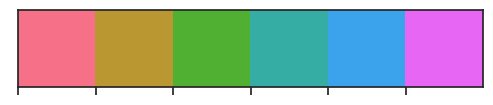

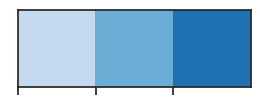

In [41]:
# Set sample (row) colors
df = sample_df.fillna(0)
palettes = [dict(zip(sorted(set(df[c[i]])), sns.color_palette(p[i], len(set(df[c[i]]))))) for i in range(len(c))]
row_colors = [[palettes[i][df.loc[x, c[i]]] for x in rxn_frac_df.index] for i in range(len(c))]

for i in range(len(c)):
    sns.palplot(palettes[i].values())
    print(sorted(set(df[c[i]])))

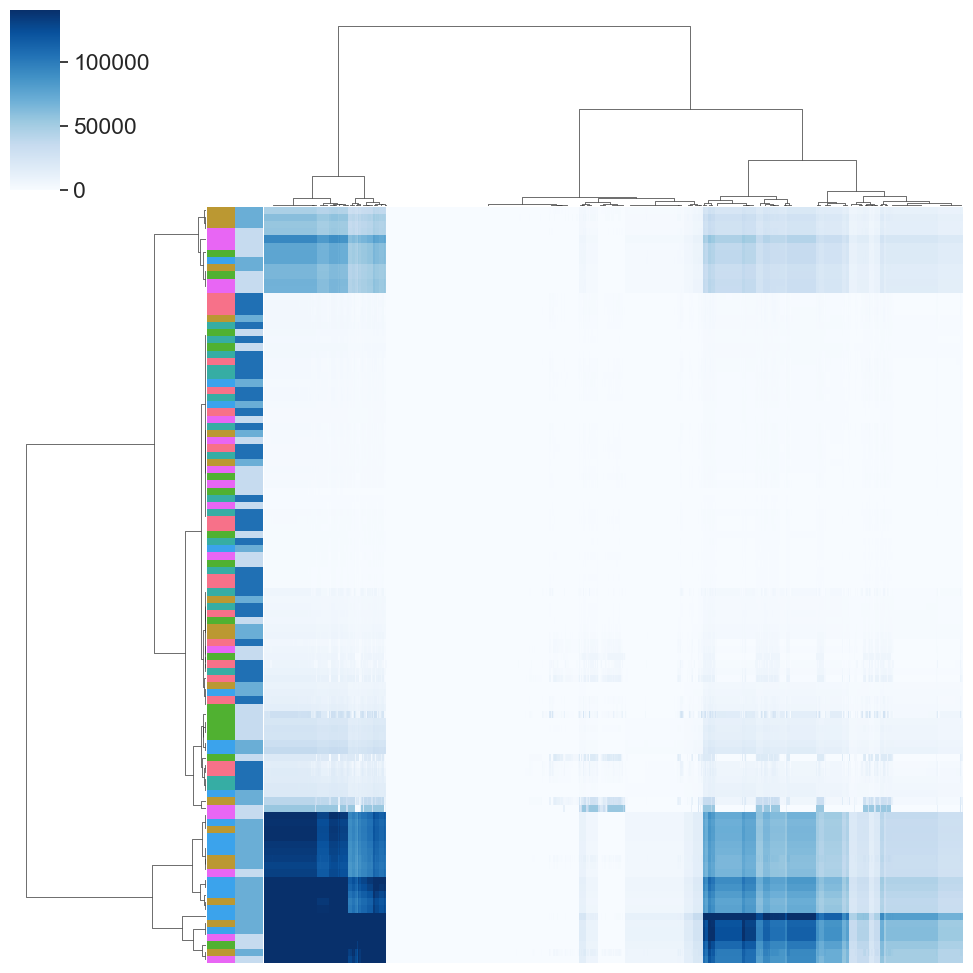

In [42]:
g = sns.clustermap(rxn_cnt_df, cmap='Blues', method='ward', xticklabels=False, yticklabels=False, robust=True, row_colors=row_colors)
g.savefig(join(plot_dir, 'clustermap_rxn_cnt_' + suffix + '.png'), bbox_inches='tight')

In [43]:
# PCA on reaction abundances
pca = PCA()
Z = StandardScaler().fit_transform(rxn_frac_df[intestine])
T = pca.fit_transform(Z)
T.shape

(105, 105)

In [44]:
n = 5
sample_df.loc[intestine, ['pc' + str(x + 1) for x in range(n)]] = T[:, :n]
sample_df

,sample.name,sample.no,sample_type,phase,region,regime,sample_regime,pc1,pc2,pc3,pc4,pc5
M-T1-Rep1,1_1_1_1,1,intestine,stimulus,whole,M,intestine.M,120.020128,49.472123,-22.072120,-42.843829,10.238773
M-T1-Rep2,1_1_1_2,7,intestine,stimulus,whole,M,intestine.M,104.197358,21.745538,-41.265905,0.918694,8.934636
M-T1-Rep3,1_1_1_3,235,intestine,stimulus,whole,M,intestine.M,22.311734,-59.689429,36.873366,-7.671600,23.756678
M-T1-Rep4,1_1_1_4,19,intestine,stimulus,whole,M,intestine.M,67.530559,-37.876744,-35.216520,32.737945,4.770416
M-T1-Rep5,1_1_1_5,215,intestine,stimulus,whole,M,intestine.M,-12.461319,-24.841039,13.108066,-1.963378,3.064576
...,...,...,...,...,...,...,...,...,...,...,...,...
VMV-T8-Rep1,3_8_1_D,95,intestine,challenge,distal,VMV,intestine.VMV,-50.281726,8.067343,0.727712,-1.963002,-1.653346
VMV-T8-Rep2,3_8_2_D,18,intestine,challenge,distal,VMV,intestine.VMV,-32.600939,12.000918,-2.600613,-2.661649,0.959838
VMV-T8-Rep3,3_8_3_D,244,intestine,challenge,distal,VMV,intestine.VMV,-50.456414,8.027143,0.758584,-1.939216,-1.688263
VMV-T8-Rep4,3_8_4_D,30,intestine,challenge,distal,VMV,intestine.VMV,-50.435646,8.034583,0.755208,-1.946622,-1.680208


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


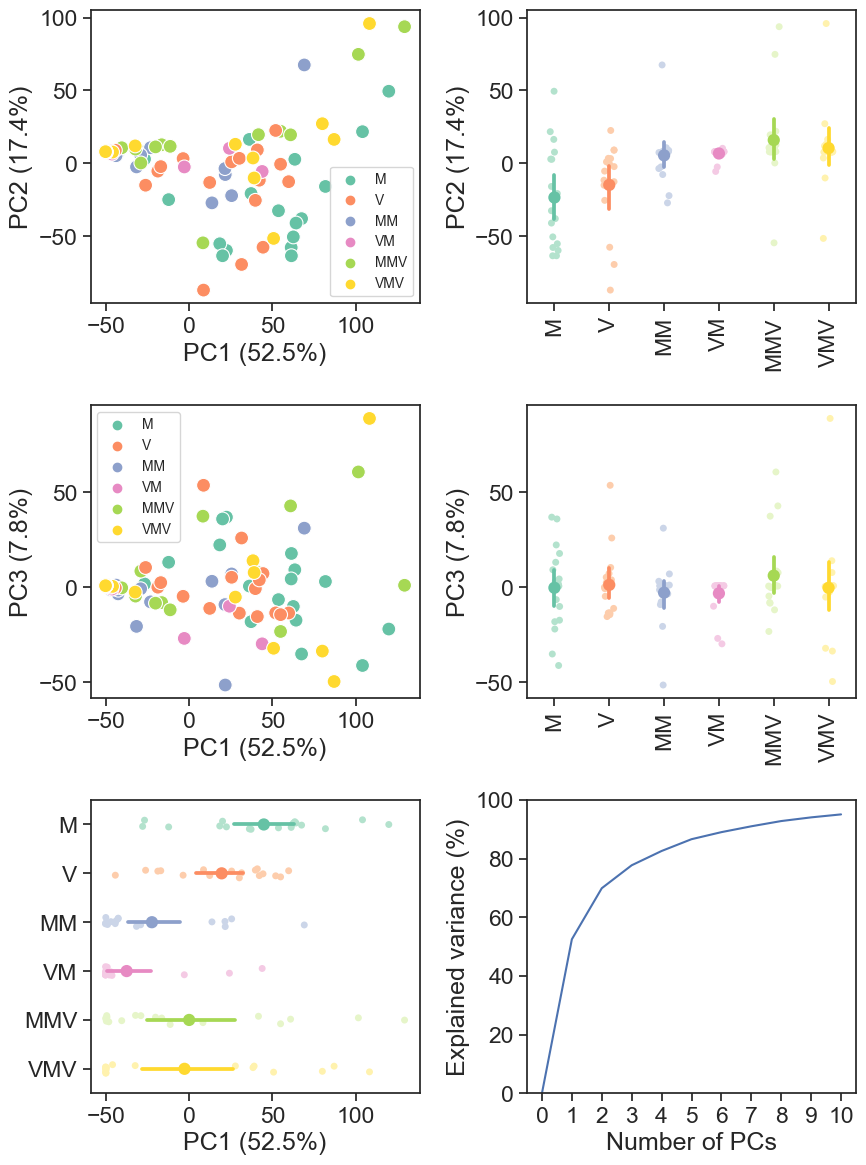

In [45]:
sns.set(style='ticks', font_scale=1.5)
f = plt.figure()

df = sample_df[intestine]
order = regime_order[suffix]

plt.subplot(3, 2, 1)
ax = sns.scatterplot(x=df.pc1, y=df.pc2, hue=df.regime, hue_order=order, palette=regime_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
# ax.legend().set_visible(False)
ax.legend(ncol=1, fontsize=10, loc='lower right').set_title(None)

plt.subplot(3, 2, 2)
ax = sns.pointplot(x=df.regime, y=df.pc2, join=False, palette=regime_palette, orient='v', order=order)
ax = sns.stripplot(x=df.regime, y=df.pc2, palette=regime_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('')
plt.ylabel('PC2 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[1]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.legend().set_visible(False)

plt.subplot(3, 2, 3)
ax = sns.scatterplot(x=df.pc1, y=df.pc3, hue=df.regime, hue_order=order, palette=regime_palette, s=100)
plt.xlabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))
plt.ylabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.legend(ncol=1, fontsize=10, loc='upper left').set_title(None)

plt.subplot(3, 2, 4)
ax = sns.pointplot(x=df.regime, y=df.pc3, join=False, palette=regime_palette, orient='v', order=order)
ax = sns.stripplot(x=df.regime, y=df.pc3, palette=regime_palette_pale, zorder=-1, orient='v', order=order)
plt.xlabel('')
plt.ylabel('PC3 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[2]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.set_yticklabels([])

plt.subplot(3, 2, 5)
ax = sns.pointplot(y=df.regime, x=df.pc1, join=False, palette=regime_palette, orient='h', order=order)
ax = sns.stripplot(y=df.regime, x=df.pc1, palette=regime_palette_pale, zorder=-1, orient='h', order=order)
plt.ylabel('')
plt.xlabel('PC1 ({:.1f}%)'.format(100 * pca.explained_variance_ratio_[0]))

plt.subplot(3, 2, 6)
n = 10
x = [0]
x.extend(range(1, n + 1))
y = [0]
y.extend(100 * np.cumsum(pca.explained_variance_ratio_[:n]))
ax = sns.lineplot(x=x, y=y)
plt.ylim(0, 100)
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance (%)')
ax.set_xticks(range(n + 1))
ax.set_xticklabels(range(n + 1))


f.set_size_inches(9, 12)
plt.tight_layout()
f.savefig(join(plot_dir, 'pca_rxn_' + suffix + '.tiff'), bbox_inches='tight')

In [46]:
# Choose multiple testing correction method
method = 'fdr_bh'

In [47]:
# Pairwise comparison of regimes for each reaction

d = defaultdict(list)
df = sample_df[intestine]

for x1, x2 in combinations(regime_order[suffix], 2):
    print(x1, x2)
    for r in rxn_frac_df.columns:
        if r.startswith('EX_') or r.startswith('sink_') or r.startswith('DM_') or r.startswith('biomass'):
            continue
        
        s = subsys[r]
        if not s or s.startswith('Transport') or s.startswith('Exchange') or s.startswith('Unassigned'):
            continue

        s1 = rxn_frac_df.loc[df[df.regime == x1].index, r]
        s2 = rxn_frac_df.loc[df[df.regime == x2].index, r]
        t, p = ttest_ind(s1, s2, equal_var=False)
        d['x1'].append(x1)
        d['x2'].append(x2)
        d['t'].append(t)
        d['p'].append(p)
        d['reaction'].append(r)
        d['subsys'].append(s)
        
rxn_comp_df = pd.DataFrame(d).dropna()

rxn_comp_df

M V
M MM
M VM
M MMV
M VMV
V MM
V VM
V MMV
V VMV
MM VM
MM MMV
MM VMV
VM MMV
VM VMV
MMV VMV


,x1,x2,t,p,reaction,subsys
0,M,V,-1.241946,0.223406,23DHMPO,"Valine, leucine, and isoleucine metabolism"
1,M,V,-1.894829,0.066967,26DAPLLAT,Lysine metabolism
2,M,V,-1.241946,0.223406,2AHBUTI,"Valine, leucine, and isoleucine metabolism"
3,M,V,-1.651366,0.110030,2MBCOATA,Glycerophospholipid metabolism
4,M,V,-1.693510,0.101684,3HAD10M12,Fatty acid synthesis
...,...,...,...,...,...,...
52428,MMV,VMV,0.667735,0.510291,L2AADIPADOR,Lysine metabolism
52429,MMV,VMV,0.667735,0.510291,L2AADIPADOR2,Lysine metabolism
52430,MMV,VMV,0.667735,0.510291,r0594,Lysine metabolism
52431,MMV,VMV,1.000000,0.332195,SQLE,Cholesterol metabolism


In [48]:
# Correct for multiple testing and save
alpha = 0.05
rxn_comp_df['padj'] = multipletests(rxn_comp_df.p, method=method)[1]
rxn_comp_df.to_csv(data_dir + '/reaction_comp.csv')
(rxn_comp_df.padj < alpha).sum()

14149

In [49]:
# Subsystem enrichment analysis (Fisher's exact test)

dd = defaultdict(list)

for x, df in rxn_comp_df.groupby(['x1', 'x2']):
    for s in sorted(set(df.subsys)):
        a = ((df.subsys == s) & (df.padj <= alpha)).sum()
        b = ((df.subsys != s) & (df.padj <= alpha)).sum()
        c = ((df.subsys == s) & (df.padj > alpha)).sum()
        d = ((df.subsys != s) & (df.padj > alpha)).sum()
        n = a + b + c + d
        
        r, p = fisher_exact([[a, b], [c, d]], alternative='greater')
        
        dd['x1'].append(x[0])
        dd['x2'].append(x[1])
        dd['subsys'].append(s)
        dd['a'].append(a)
        dd['b'].append(b)
        dd['c'].append(c)
        dd['d'].append(d)
        dd['n'].append(n)
        dd['r'].append(r)
        dd['p'].append(p)
        
        if p <= alpha:
            print(x, s, p)
            print(a, b, c, d)
        
subsys_comp_df = pd.DataFrame(dd)

subsys_comp_df

('M', 'MM') Fatty acid synthesis 0.000426778590647586
167 2410 29 810
('M', 'MM') Mucin O-glycan degradation 1.0514830836612518e-14
904 1673 178 661
('M', 'MM') Peptide metabolism 0.006171344827710582
18 2559 0 839
('M', 'MM') Valerate metabolism 0.04480021884065276
11 2566 0 839
('M', 'MMV') Butanoate metabolism 0.04191952532737192
22 1283 20 2093
('M', 'MMV') Chondroitin sulfate degradation 0.00016947960312623862
9 1296 0 2113
('M', 'MMV') Fatty acid synthesis 7.101577624698098e-10
116 1189 80 2033
('M', 'MMV') Glycerophospholipid metabolism 6.233479416885797e-21
167 1138 85 2028
('M', 'MMV') Nucleotide interconversion 0.0006571690205959925
52 1253 43 2070
('M', 'MMV') Peptide metabolism 2.7632446230960125e-08
18 1287 0 2113
('M', 'MMV') Phenylalanine metabolism 0.048018006766660695
24 1281 23 2090
('M', 'MMV') Purine synthesis 0.0008129310456217419
11 1294 2 2111
('M', 'MMV') Stickland reaction 0.008074798163570195
5 1300 0 2113
('M', 'MMV') Valerate metabolism 2.4483055719569708e-0

,x1,x2,subsys,a,b,c,d,n,r,p
0,M,MM,Alanine and aspartate metabolism,15,2562,4,835,3416,1.222190,0.483040
1,M,MM,Alkaloid synthesis,1,2576,0,839,3416,inf,0.754391
2,M,MM,Aminobenzoate degradation,2,2575,1,838,3416,0.650874,0.848744
3,M,MM,Aminophosphonate metabolism,1,2576,0,839,3416,inf,0.754391
4,M,MM,Aminosugar metabolism,10,2567,17,822,3416,0.188364,0.999996
...,...,...,...,...,...,...,...,...,...,...
1425,VM,VMV,Vitamin B6 metabolism,0,6,17,3386,3409,0.000000,1.000000
1426,VM,VMV,Vitamin C metabolism,0,6,1,3402,3409,0.000000,1.000000
1427,VM,VMV,Wood-Ljungdahl Pathway,0,6,6,3397,3409,0.000000,1.000000
1428,VM,VMV,beta-Alanine metabolism,0,6,8,3395,3409,0.000000,1.000000


In [50]:
# Correct for multiple testing and save
alpha = 0.05
subsys_comp_df['padj'] = multipletests(subsys_comp_df.p, method=method)[1]
subsys_comp_df.to_csv(data_dir + '/subsys_comp.csv')
(subsys_comp_df.padj < alpha).sum()

26

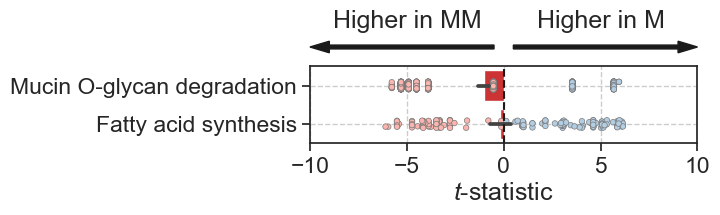

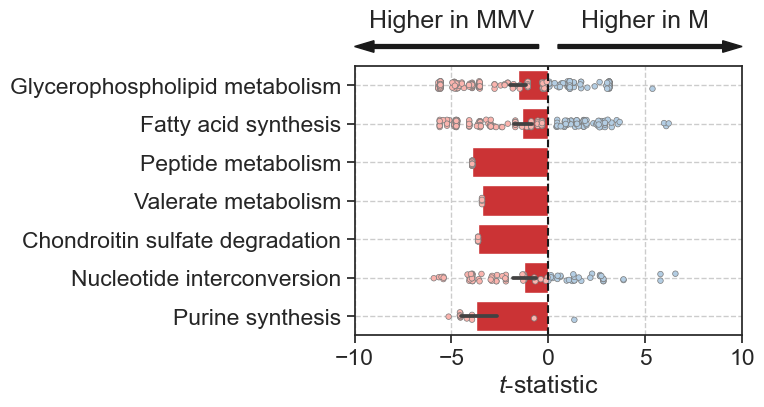

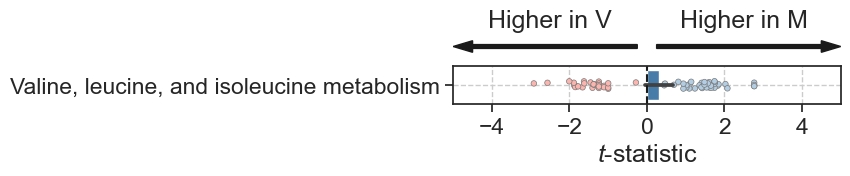

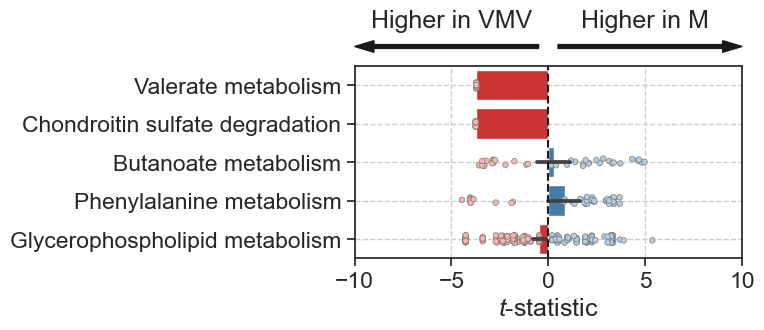

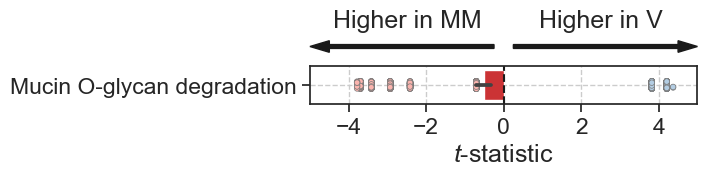

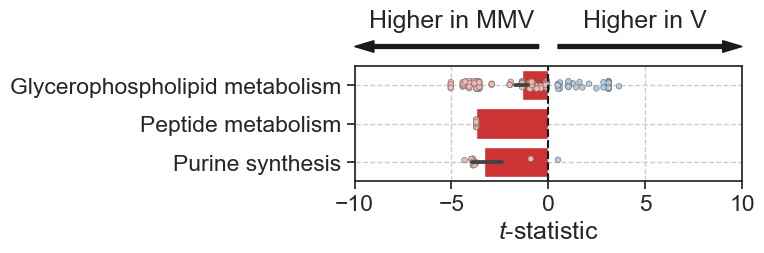

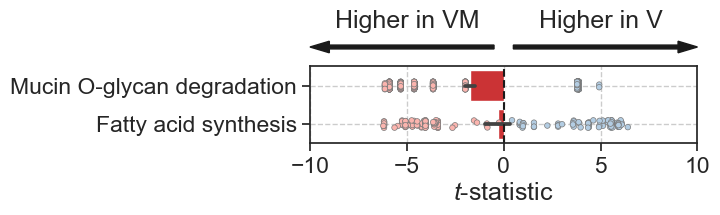

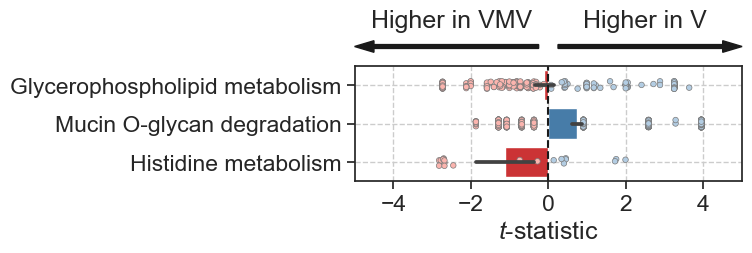

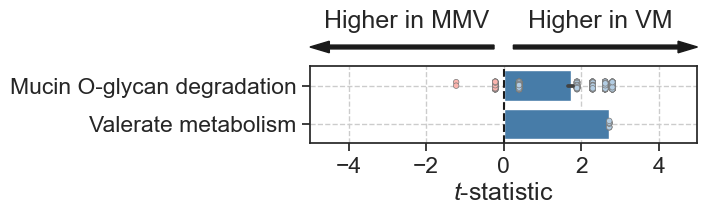

In [56]:
# Plot t-statistic for each reaction, significant subsystem, and regime pair
import random
random.seed(12345) # set seed
sns.set(style='ticks', font_scale=1.5)

alpha = 0.05

for x, df in rxn_comp_df.dropna().groupby(['x1', 'x2']): 
#     df = df[(df.subsys != '') & (df.padj < alpha)]
    df = df[(df.subsys != '')]
    
    ss_df = subsys_comp_df
    ss_df = ss_df[(ss_df.x1 == x[0]) & (ss_df.x2 == x[1]) & (ss_df.padj <= alpha)]
    ss = set(ss_df.subsys)
    
    df = df[df.subsys.isin(ss)]
    
    if df.empty:
        continue
    
    f = plt.figure()
    
    xmax = df.t.abs().max()
    xmax = np.ceil(df.t.abs().max() / 5) * 5
    xlim = -xmax, xmax
    ylim = df.subsys.nunique() - 0.5, -0.5
        
#     s = df[df.t < 0].subsys.value_counts().sort_values(ascending=False)
#     ax = plt.barh(y=s.index, width=-s.values)

#     s = df[df.t > 0].subsys.value_counts().sort_values(ascending=False)
#     plt.barh(y=s.index, width=s.values)
    t_mean = df.groupby('subsys').t.mean()
    order = list(t_mean.sort_values(ascending=True).index)
    hue = [dict(t_mean > 0)[x] for x in df.subsys] 
    
    p1 = sns.color_palette('Pastel1', 2)
    p2 = sns.color_palette('Set1', 2)
    if df.t.max() < 0:
        p1.pop()
    elif df.t.min() > 0:
        p1.pop(0)
    if t_mean.max() < 0:
        p2.pop()
    elif t_mean.min() > 0:
        p2.pop(0)
        
#     hue = df.t < 0
#     hue = df.t != 0
    
#     ss_df['recall'] = ss_df.a / ss_df[['a', 'c']].sum(1)
#     ss_df = ss_df.sort_values(by='recall', ascending=True)
#     order = ss_df.subsys
    order = ss_df.sort_values(by='padj', ascending=True).subsys

#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj < alpha], hue=hue, palette='Set1', color='#b3cde3', size=4, order=order, jitter=jitter, zorder=1)
#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj > alpha], color='#f2f2f2', size=4, order=order, jitter=jitter, zorder=1)
#     ax = sns.swarmplot(x=df.t, y=df.subsys, hue=df.padj < alpha, palette=['#999999', '#e41a1c'], size=2, order=order)
#     ax = sns.stripplot(x='t', y='subsys', data=df[df.padj < alpha], color='#e41a1c', size=5, order=order)
#     ax = sns.swarmplot(x=df.t, y=df.subsys, hue=df.padj < alpha, order=order, palette=['#d9d9d9', '#e41a1c'], size=2)
#     ax = sns.pointplot(x=df.t, y=df.subsys, order=order, join=False, color='#377eb8')
    ax = sns.stripplot(x=df.t, y=df.subsys, hue=df.t > 0, palette=p1, jitter=0.1, order=order, size=4, zorder=2, linewidth=0.5)
#     ax = sns.pointplot(x=df.t, y=df.subsys, order=order, join=False, color='#377eb8', ci=95, zorder=2)
    ax = sns.barplot(x=df.t, y=df.subsys, hue=hue, palette=p2, order=order, dodge=False, ci=95, zorder=1)
    
    plt.plot([0, 0], ylim, c='k', ls='--')
    
    plt.arrow(-0.05 * xmax, -1, -0.95 * xmax, 0, color='k', clip_on=False, width=0.1, length_includes_head=True, head_length=0.1 * xmax)
    plt.arrow(0.05 * xmax, -1, 0.95 * xmax, 0, color='k', clip_on=False, width=0.1, length_includes_head=True, head_length=0.1 * xmax)
    plt.text(-xmax / 2, -1.5, 'Higher in {}'.format(x[1]), ha='center')
    plt.text(xmax / 2, -1.5, 'Higher in {}'.format(x[0]), ha='center')

#     plt.title(' vs. '.join(x))
    plt.xlabel('Subsystem difference')
    plt.xlabel('$t$-statistic')
    plt.ylabel('')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.grid(True, ls='--')
    ax.legend().set_visible(False)
    
#     plt.subplot(1, 6, 4)
#     ax = plt.barh(y=ss_df.subsys, width=ss_df.recall, tick_label='')
    
    f.set_size_inches(5, len(set(df.subsys)) / 2)
    f.savefig(join(plot_dir, '_'.join(x).lower() + '_subsys_diff_' + suffix + '.tiff'), bbox_inches='tight')
#     break

In [57]:
# Compute mean t-statistic for each significant subsystem
d = defaultdict(dict)
alpha = 0.05
order = regime_order[suffix]
for (x1, x2), df in rxn_comp_df.groupby(['x1', 'x2']):
    ss_df = subsys_comp_df
    ss_df = ss_df[(ss_df.x1 == x1) & (ss_df.x2 == x2) & (ss_df.padj <= alpha)]
    df = df[df.subsys.isin(set(ss_df.subsys))]
    if df.empty:
        continue
    for ss in df.subsys:
        d[(x1, x2)][ss] = df[df.subsys == ss].t.mean()
        d[(x2, x1)][ss] = -df[df.subsys == ss].t.mean()
df = pd.DataFrame(d).fillna(0)
df = df.loc[df.any(1)]
df = df[list(permutations(order, 2))]
df

KeyError: "[('M', 'VM'), ('MM', 'VM'), ('MM', 'MMV'), ('MM', 'VMV'), ('VM', 'M'), ('VM', 'MM'), ('VM', 'VMV'), ('MMV', 'MM'), ('MMV', 'VMV'), ('VMV', 'MM'), ('VMV', 'VM'), ('VMV', 'MMV')] not in index"

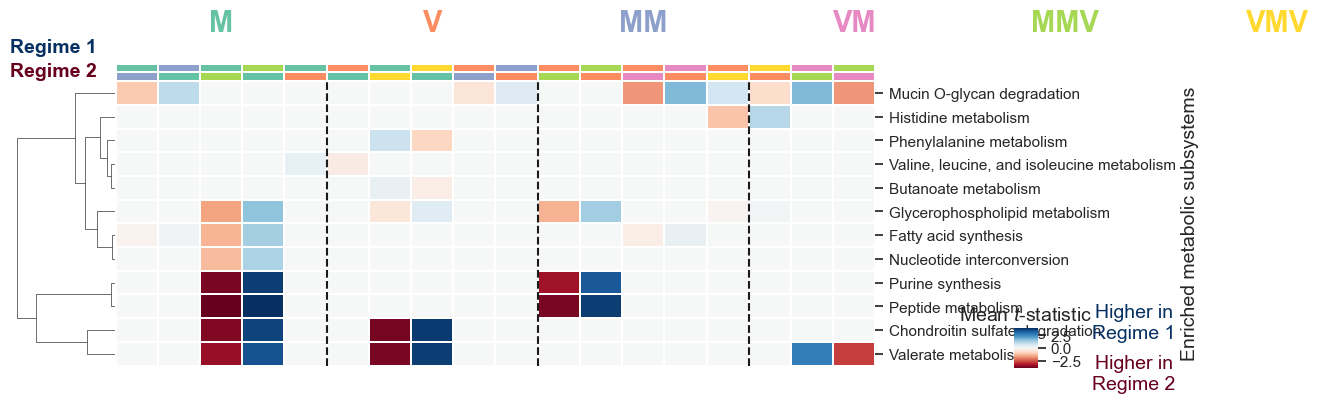

In [59]:
# Clustered heatmap of mean t-statistics (customized for data from Pabo)
if suffix == 'marwa':
    sns.set(font_scale=1)

    regimes = regime_order[suffix]

    p = dict(zip(regimes, regime_palette))
    col_colors = [[p[x[0]] for x in df.columns], [p[x[1]] for x in df.columns]]

    cbar_pos = (0.85, 0.09, 0.02, 0.1)
    figsize=(12, len(df) / 3)
    dendrogram_ratio=0.12
    colors_ratio=0.025

    g = sns.clustermap(df, yticklabels=1, cmap='RdBu', figsize=figsize, center=0, robust=False, dendrogram_ratio=dendrogram_ratio, col_colors=col_colors, cbar_pos=cbar_pos, colors_ratio=colors_ratio, method='ward', col_cluster=False, linewidth=0.1, xticklabels=False)
    for i in range(len(regimes) - 1):
        g.ax_heatmap.axvline(x=5 * (i + 1), ymin=0, ymax=len(df), c='k', ls='--')

    fontsize = 14
    g.ax_heatmap.set_xlabel('')
    g.ax_heatmap.set_ylabel('Enriched metabolic subsystems', fontsize=fontsize)
    for i, regime in enumerate(regimes):
        g.ax_heatmap.text(2.5 + i * 5, -2.1, regime, ha='center', fontsize=fontsize * 1.5, color=p[regime], weight='bold')
    g.ax_heatmap.text(-2.5, -1.2, 'Regime 1', ha='left', weight='bold', color='#053061', fontsize=fontsize)
    g.ax_heatmap.text(-2.5, -0.2, 'Regime 2', ha='left', weight='bold', color='#67001f', fontsize=fontsize)
    g.ax_cbar.text(5, 5, 'Higher in\nRegime 1', ha='center', va='center', color='#053061', fontsize=fontsize)
    g.ax_cbar.text(5, -5, 'Higher in\nRegime 2', ha='center', va='center', color='#67001f', fontsize=fontsize)
    g.ax_cbar.set_title('Mean $t$-statistic', fontsize=fontsize)

    g.savefig(join(plot_dir, 'subsys_clustermap_' + suffix + '.tiff'), bbox_inches='tight')

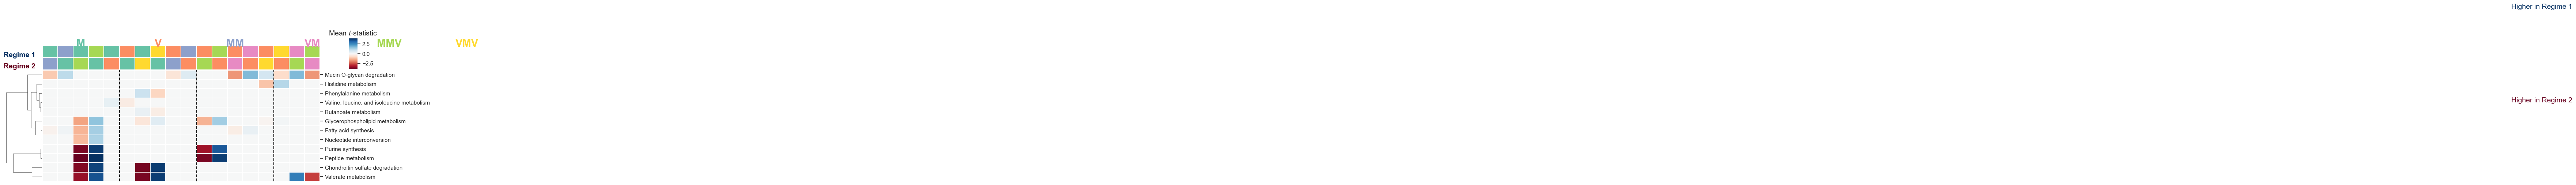

In [54]:
# Clustered heatmap of mean t-statistics (customized for data from Jeleel)
if suffix == 'marwa':
  sns.set(font_scale=1)

regimes = regime_order[suffix]

p = dict(zip(regimes, regime_palette))
col_colors = [[p[x[0]] for x in df.columns], [p[x[1]] for x in df.columns]]

cbar_pos = (0.8, 0.72, 0.02, 0.175)
figsize=(12, len(df) / 2.5)
dendrogram_ratio=0.12
colors_ratio=0.08

g = sns.clustermap(df, yticklabels=1, cmap='RdBu', figsize=figsize, center=0, robust=False, dendrogram_ratio=dendrogram_ratio, col_colors=col_colors, cbar_pos=cbar_pos, colors_ratio=colors_ratio, method='ward', col_cluster=False, linewidth=0.1, xticklabels=False)
for i in range(len(regimes) - 1):
  g.ax_heatmap.axvline(x=5 * (i + 1), ymin=0, ymax=len(df), c='k', ls='--')

fontsize = 14
g.ax_heatmap.set_xlabel('')
#     g.ax_heatmap.set_ylabel('Enriched metabolic subsystems', fontsize=fontsize)
for i, regime in enumerate(regimes):
  g.ax_heatmap.text(2.5 + i * 5, -2.5, regime, ha='center', fontsize=fontsize * 1.5, color=p[regime], weight='bold')
g.ax_heatmap.text(-2.5, -1.4, 'Regime 1', ha='left', weight='bold', color='#053061', fontsize=fontsize)
g.ax_heatmap.text(-2.5, -0.2, 'Regime 2', ha='left', weight='bold', color='#67001f', fontsize=fontsize)
g.ax_cbar.text(250, 12, 'Higher in Regime 1', ha='center', va='center', color='#053061', fontsize=fontsize)
g.ax_cbar.text(250, -12, 'Higher in Regime 2', ha='center', va='center', color='#67001f', fontsize=fontsize)
g.ax_cbar.set_title('Mean $t$-statistic', fontsize=fontsize)

g.savefig(join(plot_dir, 'subsys_clustermap_' + suffix + '.tiff'), bbox_inches='tight')